In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import pointbiserialr
import warnings
from scipy.stats import ttest_ind, mannwhitneyu
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.api as sm
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.cm as cm

import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve,  roc_auc_score
from scipy.stats import randint


from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score

import xgboost


# Load data

In [131]:
campaign = pd.read_csv('Campaigns.csv') #Load the campaign file 
campaign.isna().sum()

ParentID                  9101
Start_Date                  36
Content_Thematic_Area    19020
Content_Focus              296
Type                         0
Sub_Type                     1
Activity                    20
CampaignID                   0
Solicitation_Channel      9555
Appeal_Season                0
dtype: int64

In [132]:
superstar = pd.read_csv('student_RegularGiving.csv')  #Load the Regular Giving file

In [133]:
donations = pd.read_csv('student_Donations.csv')  #Load the donation file

In [134]:
donations['Log_Amount'] = np.log10(donations['Gift_Amount']) #Log transform the gift amount to reduce outliers

In [135]:
members = pd.read_csv('student_CampaignMembers.csv') #Load the member campaign data file

## Update new postcode data

In [136]:
update_postcode = pd.read_csv('SupporterPostcodeUpdate.csv') #Load the updated postcode
update_postcode.replace('Null', np.nan, inplace=True) #Replace the handtyped 'Null' values with Nan values for consistency

#Transform the type of postcode data from string to interger value for data consistency
update_postcode.loc[update_postcode['MailingPostcode'].notna(), 'MailingPostcode'] = update_postcode.loc[update_postcode['MailingPostcode'].notna(), 'MailingPostcode'].astype(int)

#Remove the postcode data with the value of 0 by the Nan values
update_postcode.replace(0, np.nan, inplace = True)

In [137]:
supporter = pd.read_csv('Supporters.csv') #Load the supporter file
supporter.drop(columns= 'Mailing_Postcode', inplace = True) #Drop the Postcode column

In [138]:
#Import the new postcode data from the updated file for consistency
supporter['Mailing_Postcode'] = supporter['SupporterID'].map(update_postcode.set_index('SupporterID')['MailingPostcode'])

#Rename the column for convenient purpose
supporter.rename(columns = {'Mailing_Postcode': 'Postcode'}, inplace = True)

# Fixing data

In [139]:
# Convert the all the datetime value in every table to the datetime format
campaign['Start_Date']= pd.to_datetime(campaign['Start_Date'])  
donations['Gift_Date'] = pd.to_datetime(donations['Gift_Date']) 


members['MemberCreatedDate'] = pd.to_datetime(members['MemberCreatedDate'], format='%d/%m/%Y') 
superstar['Date_Established'] = pd.to_datetime(superstar['Date_Established']) 
superstar['Cancellation_Date'] = pd.to_datetime(superstar['Cancellation_Date'])


In [140]:
#Fill missing value in Start Date column in campaign table with data from member table
a = campaign.loc[campaign['Start_Date'].isna(), 'CampaignID'].values
matching = []
for i in range(len(a)):
    if a[i] in donations['CampaignID'].values:
        matching.append(a[i]) 

In [141]:
#Fill in the rest of missing value with the earliest gift date from the donation table matching the campaign
for i in range(len(matching)): 
    
    b = sorted(donations.loc[donations['CampaignID'] == matching[i], 'Gift_Date']) 
    campaign.loc[campaign['CampaignID'] == matching[i], 'Start_Date'] = b[0] # Assume that the campaign receives the first donation on the start dates
# campaign[campaign['CampaignID'].isin(matching)]['Start_Date']

In [142]:
#Calculate the Start Date of campaign with the soonest member created date from the members table
a = campaign.loc[campaign['Start_Date'].isna(), 'CampaignID'].values

for i in range(len(a)):
    if a[i] in members['CampaignID'].values: 
        b = sorted(members.loc[members['CampaignID'] == a[i], 'MemberCreatedDate']) 
        campaign.loc[campaign['CampaignID'] == a[i], 'Start_Date'] = b[0] 
# We update the start date based on data from another table that match the campaign. We done this while assuming that members is registered on the day the campaign begins

In [143]:
#We assign the cancellation date to the active status RGID for the sake of analysis and calculations in the later part
from datetime import datetime
now = datetime.now()
superstar['Cancellation_Date'].fillna(now, inplace=True) 
superstar['Duration'] = (superstar['Cancellation_Date'] - superstar['Date_Established']).dt.days #Calculate the duration

### Group cancel reasons into groups for better analysis

In [144]:
#Grouping the Cancel reasons into groups

#0 Completed: 
superstar.loc[superstar['Cancel_Reason'].str.contains('Completed Status in RE|Signing up again|Success', case = False, na=False), 'Cancel_Reason'] = 'Complete'

# 1. Financial Difficulty
superstar.loc[superstar['Cancel_Reason'].str.contains('afford|financial difficulty|payment issue|Lost Job|COVID-19|Maternity Leave',  case=False, na=False), 'Cancel_Reason'] = 'Financial Difficulty'



#2. Bank & Payment issues
bank_terms = [
    'DD Bank Cancellation', 'Bank - credit card expired', 'Card Expired',
    'Bank - Lost/Stolen BPOINT Retoken Outcome', 'Bank - formal direct debit cancelled',
    'Bank - pick up card BPOINT Retoken Outcome', 'Bank - credit card cancelled Finance',
    'Bank - invalid transaction BPOINT Retoken Outcome',
    'Bank - invalid transaction PFS Welcome Call - Bank account not valid',
    'Bank - Lost/Stolen', 'Bank - invalid credit card number BPOINT Retoken Outcome'
]
superstar.loc[superstar['Cancel_Reason'].isin(bank_terms), 'Cancel_Reason'] = 'Banking & Payment Issues'

# 3. No Reason / No Response
no_reason_terms = [
    'No reason given', 'Constituent - no reason given Email', 'Constituent - no reason given',
    'Constituent - no reason given Phone', 'Constituent - no reason given Mondial Decline 20191106',
    'Constituent - no reason given C1to1', 'Constituent - no reason given mail',
    'Constituent - no reason given Phone - Other', 'Constituent - no reason given MonDial Upgrades 20190827',
    'Constituent - no reason given OneContact', 'Constituent - no reason given Email AD',
    'Constituent - no response to new payment details'
]
superstar.loc[superstar['Cancel_Reason'].isin(no_reason_terms), 'Cancel_Reason'] = 'No Reason / No Response'

# 4. Life Circumstances / External Factors
life_change_terms = [
    'Moving overseas', 'Constituent - moving overseas', 'Constituent - moving overseas Phone',
    'Constituent - moving overseas Email, travelling', 
    'Deceased Donor', 'Constituent - deceased C1to1', 'Constituent - deceased Phone AD',
    'Circumstances Have Changed', 'Constituent - one off intended SK COVID-19',
    '2020 Australian Bushfires Phone',  'UNICEF - other Previous multiple declines - C1to1 declines',
    'UNICEF - other C1to1, Mr Williamson deceased', 
]
superstar.loc[superstar['Cancel_Reason'].isin(life_change_terms), 'Cancel_Reason'] = 'Life Circumstances / External Factors'



# 6. Admin / Sign-up Issues
admin_terms = ['Donor sign-up error', 'Constituent - donor sign-up error Phone',
    'Constituent - donor sign-up error', 'Constituent - payment break Email'
]
superstar.loc[superstar['Cancel_Reason'].isin(admin_terms), 'Cancel_Reason'] = 'Admin / Sign-up Issue'

# 7. Dissatisfaction / Complaint
dissatisfaction_terms = [
    'Unhappy with UNICEF', 'Constituent - unhappy with UNICEF Mail', 'Not happy with the product',
    'Overwhelmed by Solicitations', 'Giving to another organisation', 'Disagree with Vaccinations',
    'Constituent - donating elsewhere Phone', 'Constituent - donating elsewhere Email', 'No Longer Interested', 'Passive Cancellation', 'Changed mind at welcome call',
    'Constituent - changed mind phone', 'One off intended'
]
superstar.loc[superstar['Cancel_Reason'].isin(dissatisfaction_terms), 'Cancel_Reason'] = 'Dissatisfaction / Complaint'



# 10. Other / Misc
misc_terms = ['Other', '4 Weekly', 'Fraudulent', 'UNICEF - other See Media and Note', 'UNICEF - other Mail', 'UNICEF - other', 'Content not suitable for younger audiences', 'Content not suitable for older audiences']
superstar.loc[superstar['Cancel_Reason'].isin(misc_terms), 'Cancel_Reason'] = 'Other / Miscellaneous'


### Fix inconsistent data from donation and superstar (regular giving) table

In [145]:
# 1. Unique RG participants from donations
donation_pairs = donations[donations['RGID'].notna()][['SupporterID', 'RGID']].drop_duplicates()

# 2. Existing records in superstar
superstar_pairs = superstar[['SupporterID', 'RGID']].drop_duplicates()

# 3. Find mismatched pairs (exist in donations, not in superstar)
missing_pairs = pd.merge(
    donation_pairs,
    superstar_pairs,
    on=['SupporterID', 'RGID'],
    how='left',
    indicator=True
).query('_merge == "left_only"').drop(columns=['_merge'])

# 4. Merge back to donations to get full record details
fix_superstar = pd.merge(
    donations,
    missing_pairs,
    on=['SupporterID', 'RGID'],
    how='inner'
)

## Discussion: 

The idea is that there are donors who are recorded as RG donors (make regular donations) but none of their donations were ever recorded in the donation table. In contrast, there are donors who have RGID in the donation table, make regular donations, but are not recorded in the superstar table. Thus, we have to fix these problems. 

In [146]:
#Fix missing RGIDs in the superstar table 


# Extract relevant columns for adding new RG entries
add_superstar = fix_superstar[['RGID', 'SupporterID', 'CampaignID']] 
add_superstar = add_superstar.copy()
add_superstar.drop_duplicates(inplace = True) # Remove duplicates to ensure uniqueness



#Calculate the average gift amount for every RGID not recorded in the superstar table
avg_gift  = fix_superstar.groupby(['SupporterID', 'RGID', 'CampaignID'])['Gift_Amount'].mean().reset_index()
add_superstar = add_superstar.merge(avg_gift, on = ['SupporterID', 'RGID', 'CampaignID'], how = 'left') 



#Calculate Date established, cancellation date, and installment frequency

# Get first and last donation dates per donor-RGID-campaign group
date_established = fix_superstar.groupby(['SupporterID', 'RGID', 'CampaignID'])['Gift_Date'].min().reset_index()
date_cancel = fix_superstar.groupby(['SupporterID', 'RGID', 'CampaignID'])['Gift_Date'].max().reset_index()

# Rename columns for clarity
date_cancel.rename(columns={'Gift_Date': 'Cancellation_Date'}, inplace =True) 
date_established.rename(columns={'Gift_Date': 'Date_Established'}, inplace =True) 

# Merge date info and calculate donation duration and frequency
date_fix = date_cancel.merge(date_established, on = ['SupporterID', 'RGID', 'CampaignID'], how = 'left')
date_fix['Duration'] = (date_fix['Cancellation_Date'] - date_fix['Date_Established']).dt.days

# Count number of donations made by each supporter
gift_count = fix_superstar.groupby(['SupporterID', 'RGID', 'CampaignID'])['Gift_Date'].size().reset_index() 
gift_count.rename(columns={'Gift_Date': 'Gift_Count'}, inplace = True)
date_fix = date_fix.merge(gift_count,on = ['SupporterID', 'RGID', 'CampaignID'], how = 'left')

date_fix['Times'] = date_fix['Duration']/ date_fix['Gift_Count'] # Compute average number of days between donations

# Assign frequency labels based on the donation interval
conditions = [
    date_fix['Times'] >= 280,
    date_fix['Times'] >= 170,
    date_fix['Times'] >= 80,
    date_fix['Times'] >= 50
]
choices = ['Annual', 'Semi-Annual', 'Quarterly', 'Bi-Monthly']

# Default = 'Monthly'
date_fix['Installment_Frequency'] = np.select(conditions, choices, default='Monthly')



#Implied Status and Cancel_Reason
date_fix['days_since_cancel'] = (now - date_fix['Cancellation_Date']).dt.days  # Calculate days since cancellation


# Define conditions for labeling the status as Active
conditions = [
    (date_fix['days_since_cancel'] <= 30) & (date_fix['Installment_Frequency'] == 'Monthly'),
    (date_fix['days_since_cancel'] <= 70) & (date_fix['Installment_Frequency'] == 'Bi-Monthly'),
    (date_fix['days_since_cancel'] <= 100) & (date_fix['Installment_Frequency'] == 'Quarterly'),
    (date_fix['days_since_cancel'] <= 200) & (date_fix['Installment_Frequency'] == 'Semi-Annual'),
    (date_fix['days_since_cancel'] <= 400) & (date_fix['Installment_Frequency'] == 'Annual')
]

choices = ['Active', 'Active', 'Active', 'Active', 'Active']

# Add static/default values for other fields
date_fix['Status'] = np.select(conditions, choices, default='Cancelled')
date_fix['Product_Initial'] = 'Global Parent'
date_fix['Product_Current'] = 'Global Parent'
date_fix['Cancel_Reason'] = 'No Reason / No Response'

date_fix['Payment_Type'] = 'Credit Card'

#Define the payment type 

# We define the payment type as Nan for less time consumming and we don't plan on analyzing the payment type. IF we do, we can quickly extract the 
#type of payment and add it to the existing number of each payment type to visualize in the future. 


# Merge back into the main add_superstar table
add_superstar = add_superstar.merge(date_fix, on = ['SupporterID', 'RGID', 'CampaignID'], how = 'left') 


add_superstar.drop(['Gift_Count',  'Times', 'days_since_cancel'], axis=1, inplace=True)
add_superstar['Solicitation_Channel'] = campaign.loc[campaign['CampaignID'].isin(add_superstar['CampaignID']), 'Solicitation_Channel']
add_superstar['Campaign_Activity'] = campaign.loc[campaign['CampaignID'].isin(add_superstar['CampaignID']), 'Activity']
add_superstar.rename(columns={'Gift_Amount': 'Amount'}, inplace = True)


In [148]:
#Add the new data into the superstartable
add_superstar = add_superstar[superstar.columns] #Match the columns in the existing superstar table
superstar_2 = pd.concat([superstar, add_superstar], ignore_index=True) 

In [149]:
rg_pair = superstar[['RGID', 'SupporterID']] #The pair of RGID and SupporterID from regular giving table

#The pair of RGID and SupporterID from the donation table
donation_pair = donations[donations['RGID'].notna()][['RGID', 'SupporterID']].drop_duplicates()

#Find the mismatched value by merge=ing the pairs together and look at values exist only in the regular giving table
missing_pair = pd.merge(rg_pair, donation_pair, on = ['SupporterID', 'RGID'], 
                        how='left', indicator = True).query('_merge == "left_only"').drop(columns = ['_merge'])
fix_donations = pd.merge(missing_pair, superstar, on  = ['SupporterID', 'RGID'], how='left' )

In [150]:
# Keep only the relevant columns for constructing donation records
add_donations = fix_donations[['SupporterID', 'RGID', 'CampaignID', 'Payment_Type', 'Amount', 'Duration', 'Installment_Frequency', 'Cancellation_Date']]
add_donations = add_donations.copy()
#Assign donations channel
add_donations['Donation_Channel'] = 'Recurring run'  # Set a default donation channel for these inferred recurring donations

#Calculate the total-amount => because it will add a signifcant amount of data and computational complexities 
#if we calculate each day for the regular donations, we calculate the total amount instead

#We calculate the number of regular donations as duration/ frequency and always round down as we assume that payment made on time 
#and any number deviate from this is early or late cancellation close to the payment date. 



# Define frequency in days for each installment type
conditions = [
    (add_donations['Installment_Frequency'] == '4 Weekly'),
    (add_donations['Installment_Frequency'] == 'Bi-Monthly'),
    (add_donations['Installment_Frequency'] == 'Quarterly'),
    (add_donations['Installment_Frequency'] == 'Semi-Annual'),
    (add_donations['Installment_Frequency'] == 'Annual')
]

choices = [28, 60, 90, 180, 360]

add_donations['division'] = np.select(conditions, choices, default= 30) 

#Assume that first donation is made at established date
add_donations['Multiple'] = (np.floor(add_donations['Duration']/ add_donations['division']) + 1).astype(int)  # Estimate number of donations made
# Total gift amount is estimated as amount per payment * number of payments
add_donations['Gift_Amount'] = add_donations['Amount'] * add_donations['Multiple']

#Gift_Date - for the sake of time value of money - we record the gift date as the last day of donation
add_donations['Gift_Date'] = add_donations['Cancellation_Date'] 
add_donations['Log_Amount'] = np.log10(add_donations['Gift_Amount']) 

# Generate the donations ID
existing_ids = set(donations['DonationID'].dropna().unique()) # Ensure no duplicate IDs

import random
import string

random.seed(0)
def generate_unique_ids(n, existing_ids, length=17):
    # Parameters:
    # - n: number of unique IDs to generate
    # - existing_ids: set of IDs that must be avoided (already in use)
    # - length: length of each generated ID (default is 17)
    
    new_ids = set() # Create an empty set to store newly generated unique IDs
    charset = string.ascii_letters + string.digits  # Allowed characters: A-Z, a-z, 0-9

    # Keep generating until we have 'n' unique IDs
    while len(new_ids) < n:
        new_id = ''.join(random.choices(charset, k=length)) # Randomly generate one ID of the specified length
        if new_id not in existing_ids and new_id not in new_ids: # Only add it if it's not in existing or already-generated IDs
            new_ids.add(new_id)
    
    return list(new_ids)




#Generate the unique DonationID
add_donations['DonationID'] = generate_unique_ids(len(add_donations), existing_ids)
add_donations = add_donations[donations.columns]
add_donations

#Add the newly reconstructed data to the table
add_donations = add_donations[donations.columns]
donations_2 = pd.concat([donations, add_donations], ignore_index=True)
donations_2['Month'] = donations_2['Gift_Date'].dt.month_name()

/home/datduong/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/datduong/miniconda3/envs/tf_gpu/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Discussion: 

Below are some of the donors have their first gift date is too unrealistic (before the UNICEF exists!!!) so we just use their second gift date as a time point and adjust the time reasonably

In [151]:
#Manually fix the unrealistic first gift date where the gift date far further in the past compared to the estalished date of UNICEF themselve

#We use the second gift date as the time point to fix the first gift date - where the first gift date and second gift date is on the same year. 
donations_2.loc[
    donations_2['DonationID']=='0062u000009Wdb8AAC',
    'Gift_Date'
] += pd.DateOffset(years=90)



donations_2.loc[
    donations_2['DonationID']=='0062u000009XzcwAAC',
    'Gift_Date'
] -= pd.DateOffset(years=50)


donations_2.loc[
    donations_2['DonationID']=='0062u000009Y07RAAS',
    'Gift_Date'
] += pd.DateOffset(years=50)

### Discussion: 

We include only donors who should be classified as RG donors if they in the RG program for at least 60 days, otherwise, they would make at most 2 donations within their duration.

In [152]:
#Real Regular donors are defined as people in the RG program for more than 60 days or newly registered and has not yet cancelled. 
real_RG_with_outliers = superstar[(superstar['Duration'] >= 60 )| ((superstar['Duration'] < 60) &
    (superstar['Status'] == 'Active'))]
#We create a seperate variable with the dataset adjusted for the missing value. 
real_RG_with_outliers_2 = superstar_2[(superstar_2['Duration'] >= 60 )| ((superstar_2['Duration'] < 60) &
    (superstar_2['Status'] == 'Active'))]

#Adjusted for the outliers
real_RG = real_RG_with_outliers[real_RG_with_outliers['Amount'] < 3000] 

real_RG_2 = real_RG_with_outliers_2[real_RG_with_outliers_2['Amount'] < 3000] 

real_RG.describe()

supporter['regular_donor'] = supporter['SupporterID'].isin(real_RG_with_outliers_2['SupporterID'])

print(f"The number of supporters who really participate in the RG program is {real_RG['SupporterID'].nunique()}")
print(f"The number of supporters who really participate in the RG program adjusted for missing values is {real_RG_2['SupporterID'].nunique()}")
print(f"The number of active RG among total RG programs is {real_RG[real_RG['Status'] != 'Cancelled'].shape[0]}")

The number of supporters who really participate in the RG program is 127042
The number of supporters who really participate in the RG program adjusted for missing values is 127052
The number of active RG among total RG programs is 24128


### We calculate the number of donation each donors make before conversion (apply for converted RGs only)

In [153]:
#Number of donations made by regular donors 

donations_RG = donations_2[donations_2['SupporterID'].isin(real_RG_with_outliers_2['SupporterID'])]

#Number of donations made by regular donors before the become regular donors 

#Group regular donors by their SupporterID and find the earliest day of each Date established - their first date to become regular donor 
established_date = real_RG_with_outliers_2.groupby('SupporterID')['Date_Established'].min()


donations_RG = donations_RG.copy()
#Create a donations table contains only supporterID of regular donor and map the first_date

donations_RG['Established_Date'] = donations_RG['SupporterID'].map(established_date)

donations_RG = donations_RG[donations_RG['Established_Date'].notna() ] #filter out regular donors with missing value in first established date

#Calculate the number of donations made before they involve in the RG program
donations_RG['Pre_Donation'] = donations_RG['Gift_Date'] < donations_RG['Established_Date'] 

#The number of donations made before the RG program
pre_donation = donations_RG[donations_RG['Pre_Donation']].groupby('SupporterID').count()
pre_donation = pre_donation['Pre_Donation']
pre_donation

SupporterID
A-1210280504548     1
A-1230205327777     2
A-1230293711732     1
A-1300223774722     2
A-1410281785120     1
                   ..
C-9990608649770    11
C-9990636182962     1
C-9990661233428     1
N-8310028657513     1
N-9090026854832     2
Name: Pre_Donation, Length: 18767, dtype: int64

In [154]:
#Identify regular donor as someone who in the qualified RG program
RG_donor = supporter[supporter['SupporterID'].isin(real_RG_with_outliers_2['SupporterID'])].copy()

#Drop unnecessary columns
RG_donor.drop(['Donor_Type', 'Mailing_Country', 'Donation.GiftDate_Last', 'Donation.GiftDate_First', 'Age_Bucket'], axis=1, inplace=True)

#Create a new set of tables with specific columns for later analysis
RG_donor_contact = RG_donor[['DoNotContact', 'DoNotPhone', 'DoNotMail', 'DoNotEmail', 'DoNotSMS']]
RG_donor_approach = RG_donor[['Have_HomePhone', 'Have_MobilePhone', 'Have_Email', 'Have_WorkPhone']] 
RG_donor_address = RG_donor[['Mailing_City', 'Mailing_State', 'Postcode']] 

In [155]:
#Engineer the prefer contact columns from Yes - True and No to False
supporter[RG_donor_approach.columns] = supporter[RG_donor_approach.columns].apply(lambda col: col.map({'Yes': True, 'No': False}).fillna(col)).infer_objects(copy=False)

In [156]:
post_code = pd.read_csv('Postcode ART.csv') #Load the postcode data

### Here we find the first gift date

In [157]:
first_gift_date = donations_2.groupby('SupporterID')['Gift_Date'].min().reset_index() #Find the first gift_date
first_gift = first_gift_date.merge(established_date, on = 'SupporterID', how='left')
first_gift

,SupporterID,Gift_Date,Date_Established
0,A-10000004946957,2024-11-23,NaT
1,A-10000014862260,2023-02-18,NaT
2,A-10000017862863,2023-03-02,NaT
3,A-10000119707495,2021-11-06,NaT
4,A-10000139533932,2022-02-28,NaT
...,...,...,...
538158,O-6010630351404,2021-01-06,NaT
538159,O-6720630312466,2020-11-27,NaT
538160,O-7030630342750,2020-09-10,NaT
538161,O-7090630311792,2021-07-06,NaT


# Feature selection

In [158]:
total_amount = donations_2[['SupporterID', 'Gift_Amount']].groupby('SupporterID').sum()
total_amount #Calculate the total amount

,Gift_Amount
SupporterID,
A-10000004946957,76.8
A-10000014862260,1400.0
A-10000017862863,67.2
A-10000119707495,35.0
A-10000139533932,178.5
...,...
O-6010630351404,452.9
O-6720630312466,52.5
O-7030630342750,525.0


### Number of RG programs each donor in (include non RG which should be 0)

In [159]:
RGID_count = real_RG_with_outliers_2[['SupporterID', 'RGID']].groupby('SupporterID').count() #Calculate the number of qualified RG programs each donor in
RGID_count.reset_index(inplace = True)
no_RG = donations_2.loc[~donations_2['SupporterID'].isin(RGID_count['SupporterID']), 'SupporterID'].drop_duplicates() #The donors who not in the qualified RG prograr
no_RG =  pd.DataFrame({
  'SupporterID': no_RG,
  'RGID'       : pd.Series(0, index=no_RG.index)
})
RGID_count = pd.concat([RGID_count, no_RG], axis = 0, ignore_index = True) #Concatenate data to have the full list

### Number of donations made beyond the RG program

In [160]:
non_RG_program = donations_2[donations_2['RGID'].isna()] #Donations not in the RG program 
non_RG_program = non_RG_program[['SupporterID', 'DonationID']] #List out each supporter with their donations not in the RG program
donations_beyond = non_RG_program.groupby('SupporterID').count() #Count the number of donations associated with each donor beyond the RG program
donations_beyond.reset_index(inplace = True)
no_beyond = donations_2.loc[(~donations_2['SupporterID'].isin(donations_beyond['SupporterID']) ), 'SupporterID'].drop_duplicates() #People who don't have donations beyond the RG program
no_beyond =  pd.DataFrame({
  'SupporterID': no_beyond,
  'DonationID'       : pd.Series(0, index=no_beyond.index)
})
donations_beyond = pd.concat([donations_beyond, no_beyond], axis = 0, ignore_index = True)
donations_beyond #Calculate the number of donations beyond the RG program each donor make

,SupporterID,DonationID
0,A-10000004946957,1
1,A-10000014862260,1
2,A-10000017862863,1
3,A-10000119707495,1
4,A-10000139533932,1
...,...,...
538158,C-8410433219479,0
538159,C-2830439384254,0
538160,C-9400461454117,0
538161,C-8230464268228,0


### Calculate the total duration as an RG donor and the register rate across each level of donations

In [161]:
total_duration = real_RG_with_outliers_2[['SupporterID', 'Duration']].groupby('SupporterID').sum() #The total duration in the RG program for each donor
total_duration.reset_index(inplace = True)

donation_effect = donations_beyond.merge(RGID_count, on = 'SupporterID', how = 'inner') #Create a new table to store the data
donation_effect['regular_donor'] = donation_effect['SupporterID'].map(supporter.set_index('SupporterID')['regular_donor']) #Identify who are the regular_donor
donation_effect['regular_donor'].fillna(False, inplace = True)

register_rate = donation_effect[donation_effect['DonationID'] > 1][['DonationID', 'regular_donor']].groupby('DonationID').mean()
duration_check = pd.merge(total_duration, donation_effect, on = 'SupporterID', how = 'inner')
register_rate.reset_index(inplace = True) #Check the effect of number of donations on the likelihood one will register in the RG program
register_rate = register_rate[register_rate['DonationID'] <= 50]
register_rate.set_index('DonationID', inplace = True)
duration_check = duration_check[duration_check['DonationID'] <= 50][['DonationID', 'Duration']].groupby('DonationID').mean() #Assess the effect of number of donations on average duration in the RG program
# duration_check = duration_check[['DonationID', 'Duration']].groupby('DonationID').mean()

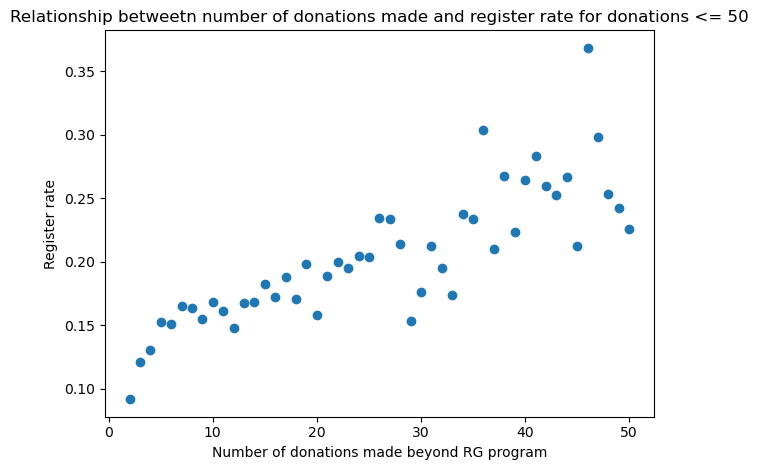

In [162]:
#Plot the register rate across level of donations
plt.scatter(register_rate.index, register_rate)
plt.ylabel('Register rate')
plt.xlabel('Number of donations made beyond RG program')
plt.title('Relationship betweetn number of donations made and register rate for donations <= 50')
plt.tight_layout()

In [163]:
#Available contact info each donor register with UNICEF

avail_contact = supporter[['SupporterID','Have_HomePhone', 'Have_MobilePhone', 'Have_Email', 'Have_WorkPhone']].copy() 
avail_contact.iloc[:, 1:] = avail_contact.iloc[:, 1:].astype(int) 
avail_contact['Index'] = avail_contact.iloc[:, 1:].sum(axis=1) 
avail_contact.set_index('SupporterID', inplace = True)
donation_effect['avail_index'] = donation_effect['SupporterID'].map(avail_contact['Index'])

In [164]:
#Matching data to the new table
donation_effect['register'] = donation_effect['DonationID'].map(register_rate['regular_donor']) 
donation_effect['duration'] = donation_effect['SupporterID'].map(total_duration.set_index('SupporterID')['Duration'])
donation_effect['Amount'] = donation_effect['SupporterID'].map(total_amount['Gift_Amount'])

In [165]:
#Prefered method contact channel by donors register with UNICEF

prefer_contact = supporter[['SupporterID','DoNotMail', 'DoNotEmail', 'DoNotPhone', 'DoNotSMS']].copy() 
prefer_contact[['DoNotMail', 'DoNotEmail', 'DoNotPhone', 'DoNotSMS']] = (prefer_contact[['DoNotMail', 'DoNotEmail', 'DoNotPhone', 'DoNotSMS']]).astype(int)
prefer_contact['Index'] = prefer_contact.iloc[:, 1:].sum(axis=1) 
prefer_contact.set_index('SupporterID', inplace = True)
donation_effect['prefer_index'] = donation_effect['SupporterID'].map(prefer_contact['Index'])

In [166]:
donation_effect['Pre_donation'] = donation_effect['SupporterID'].map(pre_donation)

### Data to include only non-converters and converters

In [167]:
#Data include converters and donors who were not acquired as RG donors 

to_train  =  donation_effect[((donation_effect['Pre_donation'] >0) & (donation_effect['RGID']>=1)) | ((donation_effect['DonationID']>=1) & (donation_effect['RGID'] == 0))].copy()
to_drop = to_train[to_train['DonationID'] == 0]
to_train = to_train[~to_train['SupporterID'].isin(to_drop['SupporterID'])]
to_train = to_train[['SupporterID', 'regular_donor']]
to_train

,SupporterID,regular_donor
0,A-10000004946957,False
1,A-10000014862260,False
2,A-10000017862863,False
3,A-10000119707495,False
4,A-10000139533932,False
...,...,...
424947,O-6010630351404,False
424948,O-6720630312466,False
424949,O-7030630342750,False
424950,O-7090630311792,False


## Discussion: 

We exclude donors whose their last donation ever 100 days before the first RG donation ever (so we say that these donors quit UNICEF before RG program ever exists)

And we also exclude donors who only recently join UNICEF (their first donation no more than 80 days from today)

In [168]:
b = donations_2['Gift_Date'].max() # The last gift date
a = superstar_2['Date_Established'].min() -  pd.Timedelta(days=100)  #The first RG gifts ever minus by 100 days

check = donations_2[['SupporterID', 'Gift_Date']].groupby('SupporterID').max() # The last gift date of each donor
check.reset_index(inplace = True)
old_donor = check[check['Gift_Date']< a ] #Old donors are donors whose last gift date much further in the past from the first RG gift ever

#the most recent time where from that time on ward, there is no one ever converted after their FIRST donation
new_donor = donation_effect[donation_effect['DonationID'] >=1].copy() 
new_donor['first'] = new_donor['SupporterID'].map(first_gift_date.set_index('SupporterID')['Gift_Date'])
new_donor['since_first'] = (b- new_donor['first']).dt.days
new_donor = new_donor[new_donor['since_first'] <= 80] #Donors are donors who just recently make their first gift

In [169]:
to_exclude = pd.concat([old_donor['SupporterID'], new_donor['SupporterID']], axis = 0) #Exclude new donors and old donors from the data analysis

,SupporterID,Gift_Date
64,A-1010199940722,1991-09-25
90,A-1020198333639,1981-10-01
117,A-1030200482803,1991-12-12
147,A-1040198808346,1988-03-01
148,A-1040198950956,1988-03-01
...,...,...
537525,C-9990072959174,1984-04-01
537526,C-9990072962479,1988-03-01
537544,C-9990088905462,1992-12-21
537550,C-9990094043599,1991-02-07


### This is the first campaign each donor attend to (this one include all UNICEF donors)

In [170]:
#Find the first campaign a donor donate to 
first_campaign = first_gift_date.merge(donations_2[['SupporterID', 'Gift_Date', 'CampaignID']], on = ['SupporterID', 'Gift_Date'], how = 'inner')
first_campaign.drop_duplicates(subset=['SupporterID', 'Gift_Date'], inplace = True)
first_campaign = first_campaign.merge(campaign, on = 'CampaignID', how = 'inner')
first_campaign

,SupporterID,Gift_Date,CampaignID,ParentID,Start_Date,Content_Thematic_Area,Content_Focus,Type,Sub_Type,Activity,Solicitation_Channel,Appeal_Season
0,A-10000004946957,2024-11-23,701RG00000UEFFeYAP,701RG00000K8y8QYAR,2024-10-27,NaN,Non-Emergency,Individual Giving,Community Fundraising,Signature Event,NaN,Null
1,A-10000014862260,2023-02-18,7018v0000009gOOAAY,7018v0000009WnQAAU,2023-01-01,Cross-Sectoral,Emergency,Individual Giving,Appeal,Unplanned Emergency,Web,Null
2,A-10000017862863,2023-03-02,7018v0000009gOOAAY,7018v0000009WnQAAU,2023-01-01,Cross-Sectoral,Emergency,Individual Giving,Appeal,Unplanned Emergency,Web,Null
3,A-10000119707495,2021-11-06,7012u00000051xBAAQ,7012u00000051wwAAA,2020-01-01,Cross-Sectoral,Non-Emergency,Individual Giving,Appeal,Always On,Web,Null
4,A-10000139533932,2022-02-28,7018v00000096uOAAQ,7018v00000096uJAAQ,2022-02-23,Cross-Sectoral,Emergency,Individual Giving,Appeal,Unplanned Emergency,Web,Null
...,...,...,...,...,...,...,...,...,...,...,...,...
537974,O-6010630351404,2021-01-06,7012u0000005NETAA2,7012u00000051vMAAQ,2020-01-01,NaN,Non-Emergency,Individual Giving,Appeal,Quarterly,DM,Christmas
537975,O-6720630312466,2020-11-27,7012u00000058ZwAAI,7012u00000051l2AAA,2020-01-01,NaN,Non-Emergency,Individual Giving,Receipt,EOFY,DM,Null
537976,O-7030630342750,2020-09-10,7012u00000059YhAAI,7012u00000051vIAAQ,2020-08-10,WASH,Non-Emergency,Individual Giving,Appeal,Quarterly,DM,Spring
537977,O-7090630311792,2021-07-06,7012u0000005lZPAAY,7012u0000005PG6AAM,2021-01-01,NaN,Non-Emergency,Individual Giving,Appeal,Quarterly,DM,Autumn


# Checking if RG donors only acquirec and converted via certain type of campaigns

In [317]:
check  = to_train.copy() 
a = check[check['regular_donor']].copy() #Query only converters
a = real_RG_with_outliers_2[real_RG_with_outliers_2['SupporterID'].isin(a['SupporterID'])] #Look up from the superstar table 
a = a[['SupporterID', 'Date_Established']].groupby('SupporterID').min() #Find the first established date for each converter
a.reset_index(inplace = True)
#Merge to find the campaign (the first one) that converters participate in as an RG
a= pd.merge(a, real_RG_with_outliers_2, on = ['SupporterID', 'Date_Established'], how = 'inner')
no_cam = a['CampaignID'].nunique() # Number of unique campaign ID
non_ca = a.loc[~a['CampaignID'].isin(campaign['CampaignID']), 'CampaignID'].nunique() #Number of campaigns in a and not in the campaign table

In [318]:
a['regular_donor'] = a['SupporterID'].map(to_train.set_index('SupporterID')['regular_donor']) #Create a new column of regular donor in dataframe a
c = to_train[~to_train['SupporterID'].isin(a['SupporterID'])] #Include only non-converters
c = c.merge(donations_2[['SupporterID', 'CampaignID']], on = 'SupporterID', how = 'left') #Merge and find all the donations non converters made
c = c[['SupporterID', 'CampaignID', 'regular_donor']] #WE only use these columns
a = a[['SupporterID', 'CampaignID', 'regular_donor']]
check = pd.concat([c, a], axis = 0) #Create a new table
check

,SupporterID,CampaignID,regular_donor
0,A-10000004946957,701RG00000UEFFeYAP,False
1,A-10000014862260,7018v0000009gOOAAY,False
2,A-10000017862863,7018v0000009gOOAAY,False
3,A-10000119707495,7012u00000051xBAAQ,False
4,A-10000139533932,7018v00000096uOAAQ,False
...,...,...,...
18226,C-9990608649770,7018v0000009UImAAM,True
18227,C-9990636182962,7012u00000052GvAAI,True
18228,C-9990661233428,7012u0000005M7TAAU,True
18229,N-8310028657513,7012u00000052HEAAY,True


In [174]:
# Build a campaign × label contingency
cmp_table = (
    check[['CampaignID','regular_donor']]  # converted = 1 for RG converters, 0 for others
    .groupby(['CampaignID','regular_donor']).size()
    .unstack(fill_value=0)
)

# Filter campaigns with enough donors
cmp_table = cmp_table[cmp_table.sum(1) >= 30]

# Chi‑square test
from scipy.stats import chi2_contingency
chi2, p, *_ = chi2_contingency(cmp_table)
print(f"Chi‑square={chi2:.2f}, p={p:.3e}")

Chi‑square=655283.39, p=0.000e+00


### The result is statistically significant which indicate that there are certain campaigns type to acquire and convert donors into RG programs

In [175]:
b = real_RG_with_outliers_2[~real_RG_with_outliers_2['SupporterID'].isin(a['SupporterID'])]
b = b[['SupporterID', 'Date_Established']].groupby('SupporterID').min()
b.reset_index(inplace = True)
b= pd.merge(b, real_RG_with_outliers_2, on = ['SupporterID', 'Date_Established'], how = 'inner')
check_num = b['CampaignID'].nunique()
#CHecking number of campaigns that convert RG donors but not used to acquire RG donors
mm_check =  a.loc[~a['CampaignID'].isin(b['CampaignID']), 'CampaignID'].nunique()
mm_check #The result indicate that almost all the campaigns used to convert donors are also use to acquire donors as RG

347

### People who are acquired through RG programs but failed to become an RG programs and never contacted by UNICEF to convert to an RG program

In [176]:
# 1. Identify which supporters are “converted” (regular donors in your main data)
converted_ids = set(to_train.loc[to_train['regular_donor']==1, 'SupporterID'])

# 2. From real_RG_with_outliers_2, pick out each SupporterID’s earliest Date_Established
first_established = (
    real_RG_with_outliers_2[['SupporterID','Date_Established','CampaignID']]
    .sort_values('Date_Established')
    .drop_duplicates(subset='SupporterID', keep='first')
)

# 3. Split into converted vs acquired 
converted_campaigns = first_established[first_established['SupporterID'].isin(converted_ids)]
acquired_campaigns  = first_established[~first_established['SupporterID'].isin(converted_ids)] #Campaigns to acquire RG donors

#Donors who were acquried as RGs but failed and were never contacted again to convert 
to_train['Donations'] = to_train['SupporterID'].map(donation_effect.set_index('SupporterID')['DonationID'])
failed = to_train[(to_train['Donations'] == 1) & (to_train['regular_donor'] == False)]
failed = failed.merge(first_campaign, on = 'SupporterID', how = 'inner')
failed = failed[failed['CampaignID'].isin(acquired_campaigns['CampaignID'])]

In [177]:
target = members[members['SupporterID'].isin(failed['SupporterID'])]
check = target.groupby('SupporterID').count()
contacted = check.sort_values('CampaignID', ascending = False)
contacted = contacted[contacted['MemberID'] >= 2] #Filter out who got targeted by UNICEF more than 2 time 
contacted.sort_values('CampaignID', ascending = True) #These are to remove
contacted.reset_index(inplace = True)

In [178]:
failed = failed.loc[~failed['SupporterID'].isin(contacted['SupporterID']), 'SupporterID']
failed

6         A-10000199479935
10        A-10000206806977
46         A-1010204761583
123        A-1050199089129
125        A-1050204003654
                ...       
264305     C-9990127626220
264310     C-9990138285712
264315     C-9990145418218
264316     C-9990147411636
264332     C-9990168028841
Name: SupporterID, Length: 16776, dtype: object

#### We can't really classify these as non-converters or not can we? or to know whether if they were to ever become an RG. Thus we exclude them

In [179]:
#To exclude donors
to_exclude = pd.concat([to_exclude, failed], axis = 0)
to_exclude.drop_duplicates(inplace = True)
to_exclude

64        A-1010199940722
90        A-1020198333639
117       A-1030200482803
147       A-1040198808346
148       A-1040198950956
               ...       
264305    C-9990127626220
264310    C-9990138285712
264315    C-9990145418218
264316    C-9990147411636
264332    C-9990168028841
Name: SupporterID, Length: 30239, dtype: object

In [180]:
to_train = to_train[~to_train['SupporterID'].isin(to_exclude)] #Data to analyze
to_train

,SupporterID,regular_donor,Donations
0,A-10000004946957,False,1
1,A-10000014862260,False,1
2,A-10000017862863,False,1
3,A-10000119707495,False,1
4,A-10000139533932,False,1
...,...,...,...
424947,O-6010630351404,False,1
424948,O-6720630312466,False,1
424949,O-7030630342750,False,1
424950,O-7090630311792,False,1


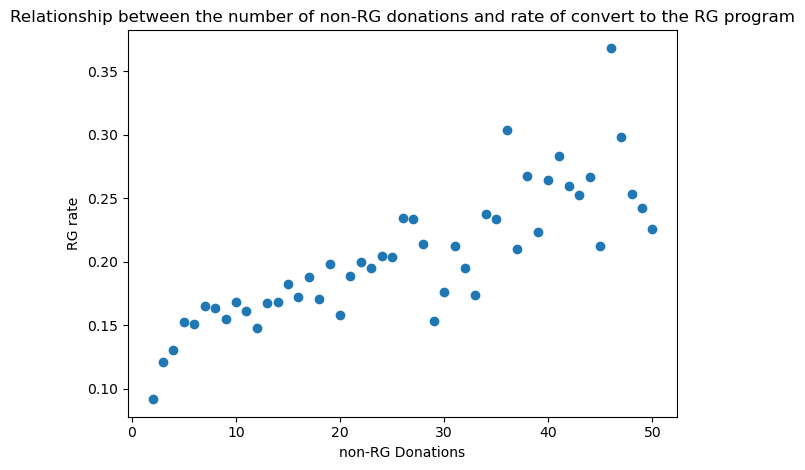

In [182]:
check_2 = donation_effect[donation_effect['SupporterID'].isin(to_train['SupporterID'])]
check_2 = check_2[check_2['DonationID'] <= 50]


check_2 = donation_effect[donation_effect['SupporterID'].isin(to_train['SupporterID'])]
check_2 = check_2[['DonationID', 'register']].groupby('DonationID').mean()
plt.scatter(check_2.index, check_2)
plt.xlabel('non-RG Donations')
plt.ylabel('RG rate')
plt.title('Relationship between the number of non-RG donations and rate of convert to the RG program')

plt.tight_layout()

## Feature engineering postcode data

In [183]:
mapping = {
    # Group A: First Class Life (Wealthiest older middle-aged families with adult children)
    'A01': {'HighIncome':1, 'LowIncome':0, 'Old':1, 'Young':0, 'Children':1, 'SchoolChildren':0, 'Couple':1},
    'A02': {'HighIncome':1, 'LowIncome':0, 'Old':1, 'Young':0, 'Children':1, 'SchoolChildren':0, 'Couple':1},
    'A03': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':1},
    'A04': {'HighIncome':1, 'LowIncome':0, 'Old':1, 'Young':0, 'Children':1, 'SchoolChildren':0, 'Couple':1},

    # Group B: Comfortable Foundations (Gen X families with school-aged children)
    'B05': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':1, 'Couple':1},
    'B06': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':1, 'Couple':1},
    'B07': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':1, 'Couple':1},

    # Group C: Striving for Status (Young professionals, high income, no children)
    'C08': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'C09': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'C10': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':1},

    # Group D: Secure Tranquility (Affluent retirees)
    'D11': {'HighIncome':1, 'LowIncome':0, 'Old':1, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':1},
    'D12': {'HighIncome':1, 'LowIncome':0, 'Old':1, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':1},
    'D13': {'HighIncome':1, 'LowIncome':0, 'Old':1, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':1},

    # Group E: Family Fringes (Middle-aged traditional families)
    'E14': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':1, 'Couple':1},
    'E15': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':0, 'Couple':1},
    'E16': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':0, 'Couple':1},

    # Group F: Establishing Roots (Millennial first-home buyers)
    'F17': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':1},
    'F18': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':1, 'Children':1, 'SchoolChildren':0, 'Couple':1},
    'F19': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':1},

    # Group G: Growing Independence (Educated millennials renting, no children)
    'G20': {'HighIncome':0, 'LowIncome':0, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'G21': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'G22': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'G23': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':0},

    # Group H: Middle Blue-Collars (Younger blue-collar workers)
    'H24': {'HighIncome':0, 'LowIncome':0, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'H25': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':1, 'Children':1, 'SchoolChildren':1, 'Couple':1},
    'H26': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'H27': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':1, 'Children':0, 'SchoolChildren':0, 'Couple':0},

    # Group I: Traditional Pursuits (Families & single parents with school-aged children)
    'I28': {'HighIncome':0, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':1, 'Couple':1},
    'I29': {'HighIncome':1, 'LowIncome':0, 'Old':1, 'Young':0, 'Children':1, 'SchoolChildren':1, 'Couple':1},
    'I30': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':1, 'Couple':1},

    # Group J: True Grit (Blue-collar households, mixed)
    'J31': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':1, 'Couple':0},
    'J32': {'HighIncome':1, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':1, 'Couple':1},
    'J33': {'HighIncome':0, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':1},
    'J34': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':0},

    # Group K: Mature Freedom (Gen X couples without children)
    'K35': {'HighIncome':0, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':1},
    'K36': {'HighIncome':0, 'LowIncome':0, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':1},
    'K37': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':1},

    # Group L: Hardship & Perseverance (Unemployed/blue-collar, low income)
    'L38': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':1, 'Couple':0},
    'L39': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':0, 'Children':1, 'SchoolChildren':1, 'Couple':0},
    'L40': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'L41': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'L42': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':1, 'Children':1, 'SchoolChildren':1, 'Couple':0},

    # Group M: Graceful Ageing (Older retirees, low income)
    'M43': {'HighIncome':0, 'LowIncome':1, 'Old':1, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':1},
    'M44': {'HighIncome':0, 'LowIncome':1, 'Old':1, 'Young':0, 'Children':1, 'SchoolChildren':0, 'Couple':1},
    'M45': {'HighIncome':0, 'LowIncome':1, 'Old':1, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'M46': {'HighIncome':0, 'LowIncome':1, 'Old':1, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':1},
    'M47': {'HighIncome':0, 'LowIncome':1, 'Old':1, 'Young':0, 'Children':1, 'SchoolChildren':0, 'Couple':1},

    # Group N: Rural Commitment (Rural farmers, low income)
    'N48': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'N49': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'N50': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':0},
    'N51': {'HighIncome':0, 'LowIncome':1, 'Old':0, 'Young':0, 'Children':0, 'SchoolChildren':0, 'Couple':0},
}

In [184]:
idx = np.r_[0, np.arange(15, post_code.shape[1])]
post = post_code.columns[0] #The postcode 
postcode_new = post_code.columns[15:] #The group of household in that postcode
postcode_new = post_code[[post] + list(postcode_new)].copy() #Merge back the Postcode to the newly created data

postcode_new.fillna(0, inplace = True)

postcode_new.set_index('Postcode', inplace =True)
population = postcode_new.iloc[:, :].sum(axis=1) #Calculate the population in each postcode
postcode_new.reset_index(inplace =True)
postcode_new['Population'] = postcode_new['Postcode'].map(population)
postcode_new = postcode_new[postcode_new['Population']>=10]
postcode_new.drop(columns = 'Population', inplace =True)


postcode_new.set_index('Postcode', inplace = True)
postcode_rate = postcode_new.div(population, axis = 0) #Calculate the rate in each postcode


In [185]:
map_df = pd.DataFrame.from_dict(mapping, orient='index') #Map the groups created match each household type

In [186]:
postcode_grouped = postcode_new.dot(map_df)

# Rename columns: 
postcode_grouped.columns = [
    'High_Income', 'Low_Income', 'Old', 
    'Young', 'Children', 'School_aged', 'Couple'
]

In [187]:
grouped_rate = postcode_grouped.div(population, axis = 0) #calculate the rate 
grouped_rate

,High_Income,Low_Income,Old,Young,Children,School_aged,Couple
Postcode,,,,,,,
800,0.683258,0.018100,0.000714,0.990712,0.000238,0.000000,0.686354
810,0.657818,0.085983,0.182905,0.342036,0.463973,0.418393,0.845099
812,0.641363,0.107436,0.291066,0.155499,0.669353,0.635426,0.932853
820,0.655754,0.088009,0.104887,0.719002,0.150607,0.073542,0.702866
822,0.125384,0.840583,0.032753,0.092375,0.116684,0.002303,0.133316
...,...,...,...,...,...,...,...
7466,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7467,0.000000,1.000000,0.001787,0.000894,0.001787,0.000000,0.001787
7468,0.001845,0.998155,0.014760,0.027675,0.035055,0.022140,0.029520


In [188]:
supporter['regular_donor'] = supporter['SupporterID'].isin(real_RG_with_outliers_2['SupporterID']) #Create a new column of regular donor

In [189]:
postcode_data = supporter[['SupporterID', 'Postcode']].copy() #Create a new postcode dataframe
postcode_data['regular_donor'] = postcode_data['SupporterID'].map(supporter.set_index('SupporterID')['regular_donor']) #Map the regular donor value
postcode_data['regular_donor'] = postcode_data['regular_donor'].astype(int) #Transform to 1 and 0 values
postcode_data = postcode_data.merge(grouped_rate.reset_index(), on = 'Postcode', how = 'left')
postcode_data.dropna(subset='Postcode',inplace = True)

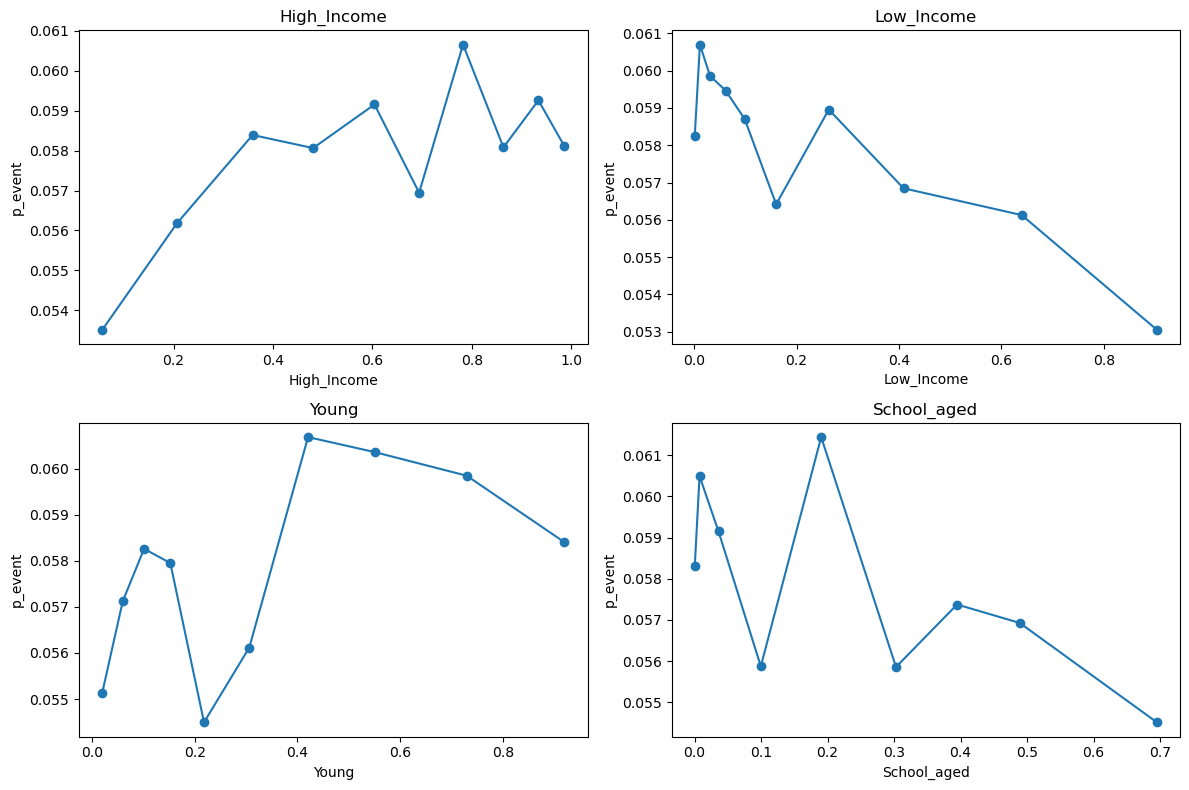

In [190]:
check = postcode_data[postcode_data['SupporterID'].isin(to_train['SupporterID'])].copy()
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes = axes.flatten()
for ax, feat in zip(axes, ['High_Income','Low_Income','Young','School_aged']): #Loop and plot the relationship with the rate of conversion
    check['bin'] = pd.qcut(check[feat], 10, duplicates='drop') #Group into 10 groups
    grp = check.groupby('bin').agg(
        mid=(feat,'mean'), 
        rate=('regular_donor','mean') #Caculate the rate
    ).reset_index()
    ax.plot(grp['mid'], grp['rate'], marker='o')
    ax.set_title(feat)
    ax.set_xlabel(feat); ax.set_ylabel('p_event')

plt.tight_layout()
plt.show()

In [191]:
#Using the raw proportion with pointbiserial correlation to assess the correlation
check = postcode_data[postcode_data['SupporterID'].isin(to_train['SupporterID'])].copy()
check.dropna(inplace =True)
col_name = ['High_Income', 'Low_Income', 'Old', 'Young', 'Children', 'School_aged', 'Couple']
for col in col_name:

    r, p = pointbiserialr(check[col], check['regular_donor'])
    print(f' {col} correlation: {r:.3f}, pvalue: {p:.3f}')

 High_Income correlation: 0.006, pvalue: 0.002
 Low_Income correlation: -0.008, pvalue: 0.000
 Old correlation: 0.000, pvalue: 0.987
 Young correlation: 0.004, pvalue: 0.019
 Children correlation: -0.005, pvalue: 0.011
 School_aged correlation: -0.006, pvalue: 0.002
 Couple correlation: 0.001, pvalue: 0.579


### Create new columns of category variables to classify each postcode into certain type. 

In [192]:
#Apply for all donors not only for the people who we will consider
postcode_data['Middle_Income'] = 1- postcode_data['High_Income'] - postcode_data['Low_Income'] 
postcode_data['filter_income'] = postcode_data[['High_Income', 'Middle_Income', 'Low_Income']].idxmax(axis=1)

# Assign the dominant income group (High, Middle, or Low) as a new categorical label
postcode_data['Middle'] = 1 - postcode_data['Old'] - postcode_data['Young']

# Assign the dominant age group (Old, Young, or Middle) as a new categorical label
postcode_data['filter_age'] = postcode_data[['Old', 'Young', 'Middle']].idxmax(axis=1)
postcode_data['No_Children'] = 1 - postcode_data['School_aged']

# Assign dominant child category
postcode_data['filter_children'] = postcode_data[['School_aged', 'No_Children']].idxmax(axis =1)

postcode_data['Single'] = 1 - postcode_data['Couple']
# Assign dominant relationship status
postcode_data['filter_couple'] = postcode_data[['Couple', 'Single']].idxmax(axis = 1)

# Drop intermediate computed columns that were only used for generating categorical labels
postcode_data.drop(columns = ['Middle_Income', 'Middle', 'No_Children', 'Single'], inplace = True)
postcode_data

,SupporterID,Postcode,regular_donor,High_Income,Low_Income,Old,Young,Children,School_aged,Couple,filter_income,filter_age,filter_children,filter_couple
0,C-3030020927884,2022.0,0,0.970834,0.002372,0.124477,0.744767,0.123081,0.000000,0.584008,High_Income,Young,No_Children,Couple
1,C-33500210211000,2067.0,0,0.985894,0.005438,0.279487,0.674031,0.266655,0.000425,0.336081,High_Income,Young,No_Children,Single
2,C-3220021369131,3977.0,0,0.580327,0.244093,0.098642,0.390568,0.777961,0.495087,0.932163,High_Income,Middle,No_Children,Couple
3,C-3640021990181,2086.0,0,0.992093,0.006977,0.951628,0.001163,0.964651,0.028605,0.999302,High_Income,Old,No_Children,Couple
4,C-4960021270990,2151.0,0,0.649438,0.285583,0.315036,0.479487,0.242494,0.168806,0.572313,High_Income,Young,No_Children,Couple
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661285,N-7430028850408,2010.0,0,0.957459,0.040293,0.000000,0.932672,0.000000,0.000000,0.737434,High_Income,Young,No_Children,Couple
661286,N-5920028265380,2195.0,0,0.089595,0.908799,0.085100,0.785806,0.128666,0.126204,0.168593,Low_Income,Young,No_Children,Single
661287,N-7430028386646,3000.0,0,0.199443,0.800532,0.000000,0.999871,0.000000,0.000000,0.178874,Low_Income,Young,No_Children,Single
661289,N-6750028740930,5038.0,0,0.243498,0.614865,0.194799,0.289776,0.099312,0.043090,0.822412,Low_Income,Middle,No_Children,Couple


In [193]:
#Create a dummy attriburte from the previous classification

# One-hot encode the categorical demographic filters (excluding the first category to avoid multicollinearity)
attributes_dummy  = pd.get_dummies(postcode_data[['filter_income', 'filter_age', 'filter_children']], drop_first = True)
attributes_dummy = attributes_dummy.astype(int)# Ensure all dummy variables are integers (0 or 1)

postcode_dummy = postcode_data[['SupporterID', 'Postcode']]
attributes_dummy= pd.concat([postcode_dummy, attributes_dummy], axis = 1) # Match each demographic to their supporters info
attributes_dummy['regular_donor'] = attributes_dummy['SupporterID'].map(supporter.set_index('SupporterID')['regular_donor'])
attributes_dummy['regular_donor'] = attributes_dummy['regular_donor'].astype(int)
attributes_dummy.head(8)

,SupporterID,Postcode,filter_income_Low_Income,filter_income_Middle_Income,filter_age_Old,filter_age_Young,filter_children_School_aged,regular_donor
0,C-3030020927884,2022.0,0,0,0,1,0,0
1,C-33500210211000,2067.0,0,0,0,1,0,0
2,C-3220021369131,3977.0,0,0,0,0,0,0
3,C-3640021990181,2086.0,0,0,1,0,0,0
4,C-4960021270990,2151.0,0,0,0,1,0,0
5,C-6500022875752,2071.0,0,0,1,0,0,0
6,C-5800022912218,6164.0,0,0,0,0,0,0
7,C-2040022965523,2137.0,0,0,1,0,0,0


In [194]:
check = postcode_data.copy()
check = check[check['SupporterID'].isin(to_train['SupporterID'])]
check = check[['SupporterID', 'regular_donor', 'filter_income', 'filter_age', 'filter_children', 'filter_couple']]
cross_1   = pd.crosstab(check['filter_income'], check['regular_donor'] )
cross_1['rate'] = cross_1[1] / (cross_1[0] + cross_1[1])
print(cross_1)

regular_donor       0      1      rate
filter_income                         
High_Income    191242  11937  0.058751
Low_Income      68061   3946  0.054800
Middle_Income   14658    934  0.059903


In [195]:
cross_2  = pd.crosstab(check['filter_age'],check['regular_donor'])
cross_2['rate'] = cross_2[1] / (cross_2[0] + cross_2[1])
print(cross_2)

regular_donor       0     1      rate
filter_age                           
Middle         115271  6869  0.056239
Old             63420  3891  0.057806
Young           95270  6057  0.059777


In [196]:
cross_3 = pd.crosstab( check['filter_children'],check['regular_donor'])
cross_3['rate'] = cross_3[1] / (cross_3[0] + cross_3[1])
print(cross_3)

regular_donor         0      1      rate
filter_children                         
No_Children      235420  14571  0.058286
School_aged       38541   2246  0.055067


In [197]:
cross_4= pd.crosstab(check['filter_couple'], check['regular_donor'])
cross_4['rate'] = cross_4[1] / (cross_4[0] + cross_4[1])
print(cross_4)

regular_donor       0      1      rate
filter_couple                         
Couple         208949  12886  0.058088
Single          65012   3931  0.057018


### Feature engineering contact information data - this is Chloe's idea

In [198]:
# Feature Engineering for Email Contact

col_name = ['SupporterID', 'Have_HomePhone', 'Have_MobilePhone', 'Have_Email', 'Have_WorkPhone', 'DoNotMail', 'DoNotEmail', 'DoNotPhone', 'DoNotSMS', 'DoNotContact']

contact_info = supporter[col_name].copy()

contact_info['Email_Reach'] = ((contact_info['Have_Email'] == True) 
                             & (contact_info['DoNotEmail'] == False)
                             & (contact_info['DoNotContact'] == False)).astype(int)

# Feature Engineering for SMS Contact
contact_info['SMS_Reach'] = ((contact_info['Have_MobilePhone'] == True) 
                           & (contact_info['DoNotSMS'] == False)
                           & (contact_info['DoNotContact'] == False)).astype(int)

# Feature Engineering for Phone Contact
contact_info['Phone_Reach'] = (((contact_info['Have_MobilePhone'] == True) 
                                   | (contact_info['Have_HomePhone'] == True) 
                                   | (contact_info['Have_WorkPhone'] == True))  
                             & (contact_info['DoNotPhone'] == False)
                             & (contact_info['DoNotContact'] == False)).astype(int)

# Feature Engineering for Mail Contact
contact_info['Mail_Reach'] = ((contact_info['DoNotMail'] == False) 
                      & (contact_info['DoNotContact'] == False)).astype(int)

# Feature Engineering for General Contact Scoring 
contact_info['Contactability'] = (contact_info['Email_Reach']
                                + contact_info['SMS_Reach']
                                + contact_info['Phone_Reach']
                                + contact_info['Mail_Reach'])

# Dropping initial columns, which have been substituted by new ones
contact_info = contact_info.drop(['Have_Email', 
                                         'Have_MobilePhone', 
                                         'Have_HomePhone',
                                         'Have_WorkPhone',
                                         'DoNotEmail',
                                         'DoNotSMS',
                                         'DoNotPhone',
                                         'DoNotMail',
                                         'DoNotContact'], axis = 1)

In [199]:
#Map the contacability score to the  donation table
donation_effect['contact_index'] = donation_effect['SupporterID'].map(contact_info.set_index('SupporterID')['Contactability'])

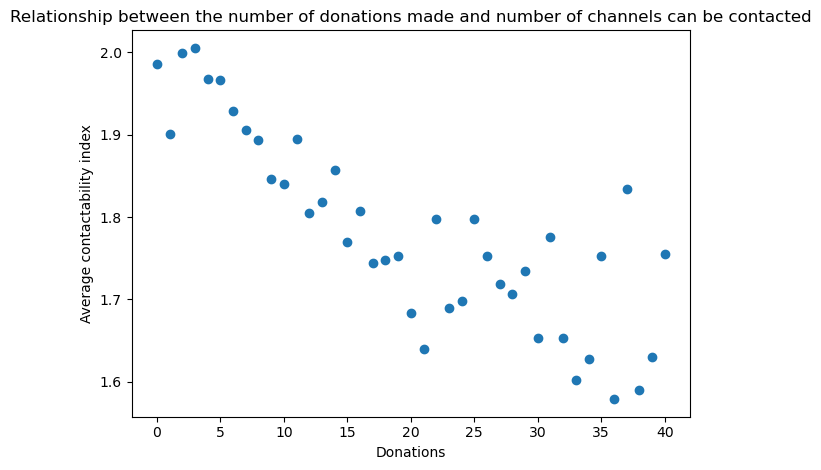

In [200]:
check = donation_effect[donation_effect['DonationID'] <= 40]
check = check[['DonationID', 'contact_index']].groupby('DonationID').mean()
plt.scatter(check.index, check)
plt.ylabel('Average contactability index')
plt.xlabel('Donations')
plt.title('Relationship between the number of donations made and number of channels can be contacted')
plt.tight_layout()

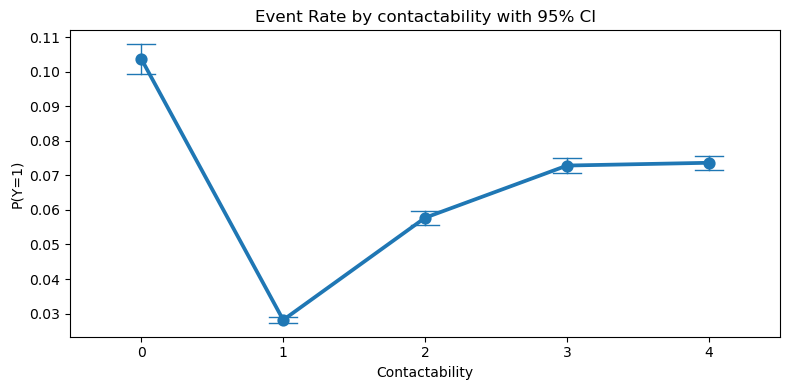

In [201]:
effect_contact = contact_info.copy()
effect_contact = effect_contact[['SupporterID', 'Contactability']]
effect_contact['regular_donor'] = effect_contact['SupporterID'].map(to_train.set_index('SupporterID')['regular_donor']) 

#Data here only include converters and non_RG
effect_contact.dropna(inplace = True)
effect_contact['regular_donor'] = effect_contact['regular_donor'].astype(int)

plt.figure(figsize=(8,4))
sns.pointplot(
    x='Contactability',
    y='regular_donor',
    data=effect_contact,
    color='C0',
    capsize=.2,
    errwidth=1,
    ci=95,
    order=sorted(effect_contact['Contactability'].unique())  # ensures it plots in numeric order
)
plt.xlabel('Contactability')
plt.ylabel('P(Y=1)')
plt.title('Event Rate by contactability with 95% CI')
plt.tight_layout()
plt.show()

In [202]:
check = donation_effect[(donation_effect['DonationID'] >= 3) & (donation_effect['RGID']==0)]
check_2 = donation_effect[(donation_effect['DonationID'] >= 3) & (donation_effect['RGID'] >=1 )]

check_non = donations_2[donations_2['SupporterID'].isin(check['SupporterID'])]

check_converted = donations_2[donations_2['SupporterID'].isin(check_2['SupporterID'])]
check_converted = check_converted[check_converted['RGID'].isna()]

In [203]:
common_month_rg = (
    check_converted
    .groupby('SupporterID')['Month']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index(name='month')
)

common_month_sg = (
    check_non
    .groupby('SupporterID')['Month']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index(name='month')
)

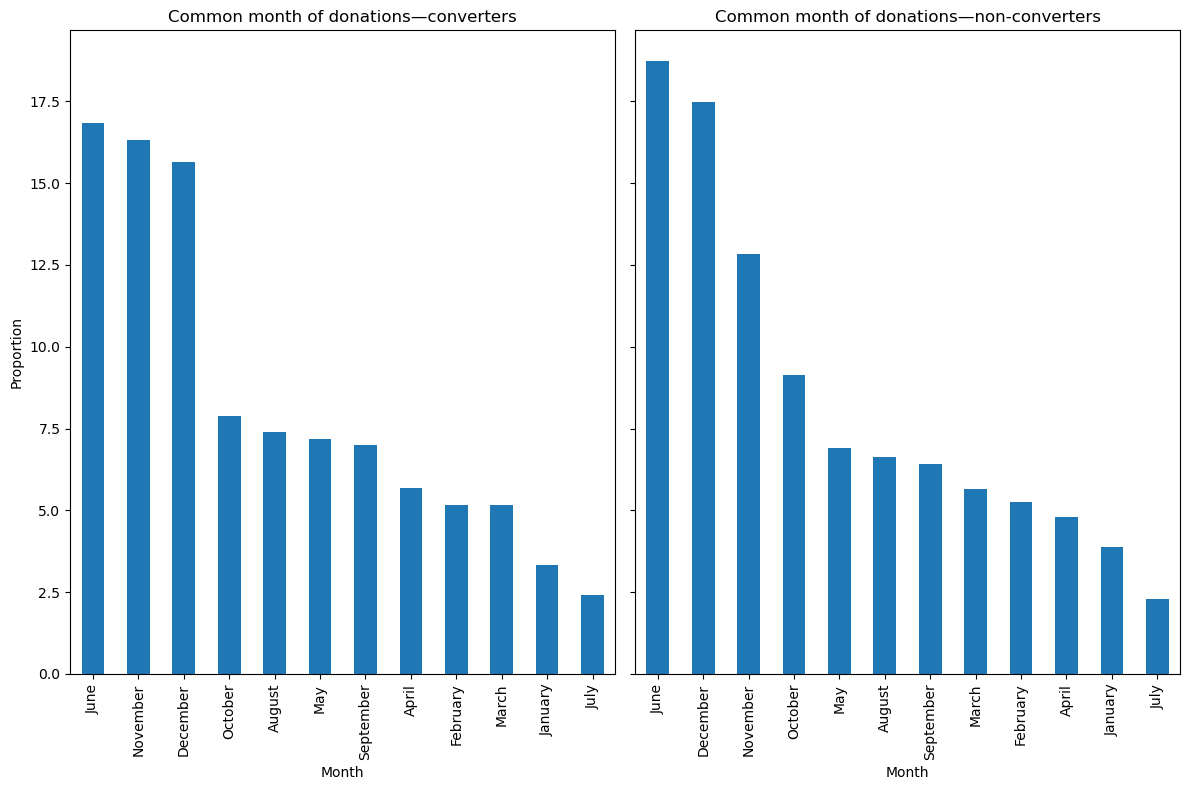

In [204]:
fig, ax =plt.subplots(1,2,figsize=(12, 8), sharey= True)

common_rg = common_month_rg['month'].value_counts()
common_sg= common_month_sg['month'].value_counts()

common_rg = common_rg/ len(common_month_rg) *100
common_sg = common_sg/ len(common_month_sg) * 100

common_rg.plot(kind = 'bar', ax=ax[0])
common_sg.plot(kind = 'bar', ax=ax[1])

ax[0].set_title('Common month of donations—converters')
ax[1].set_title('Common month of donations—non-converters')

for a in ax:
    a.set_xlabel('Month')
    a.set_ylabel('Proportion')

plt.tight_layout()
plt.show()

## From this point onward, you will see me group channels, etc. into group for easier analysis

In [205]:
# Define channel groups
mass_media = ['Media',  'TV', 'Radio', 'DRTV']

telemarketing_media = [
    'Telemarketing', 'Phone', 'SMS', 'PSMS', 'Fax' 
]

in_person = [
    'Door to door', 'F2F', 'Retail', 'Event', 'Travel Trip', 'Member Get Member', 'B2B', 'Outdoor Advertising'
]

direct_mail = [
    'DM', 'Inserts', 'Insert', 'Newspaper', 'Press'
]

digital_online = [
    'Web',  'Proposal', 'Cold', 'EDM' 
]

other_channels = [
    'Unsolicited',  'Unknown', 'Other', 'General', 'Omni Channel'
]


# Map channels into broader categories
def classify_channel(channel):
    if channel in telemarketing_media:
        return 'Telemarketing'
    elif channel in in_person:
        return 'In-Person'
    elif channel in direct_mail:
        return 'Direct Mail'
    elif channel in digital_online:
        return 'Digital/Online'
    elif channel in other_channels:
        return 'Other/Passive'
    elif channel in mass_media: 
        return 'Mass Media'
    else:
        return 'Other media channel'


In [206]:
# Define your campaign‐level groups
signature_events    = ['Signature Event', 'Water Walk', 'Vaccinaid', 'EOFY', 'Running', 'CookFor']
standard_appeals    = ['Acquisition', 'Quarterly', 'Always On', 'Conversion',
                       'Unplanned Emergency', 'Reactivation']
corporate_partner   = ['Corporate Cards', 'Consumer Cards', 'Paypal Giving Fund',
                       'Third Party', 'Lead Gen']
gifts    = ['Inspired Gifts', 'Gifts That Give', 'Challenges', 'Events', 'Event']
engagement_steward  = ['Newsletter', 'CEO Insider', 'Hub', 'Survey']
miscellaneous       = ['General', 'UA Led']

def classify_campaign(cam):
    if pd.isna(cam):
        return 'Unclassified activities'
    if cam in signature_events:
        return 'Signature Event'
    elif cam in standard_appeals:
        return 'Standard Appeal'
    elif cam in corporate_partner:
        return 'Corporate/Partner'
    elif cam in gifts:
        return 'Gifts'
    elif cam in engagement_steward:
        return 'Engagement/Stewardship'
    elif cam in miscellaneous:
        return 'Miscellaneous'
    else:
        return 'Other activity'

In [207]:
def categorize_sub_type(sub):
    if sub in ['Appeal']:
        return 'Appeal'
    else:
        return 'Global Parent and Others'



In [208]:
first_campaign['Channel_Group'] = first_campaign['Solicitation_Channel'].apply(classify_channel)
first_campaign['Month'] = first_campaign['Gift_Date'].dt.month_name()
first_campaign['Activity_Group'] = first_campaign['Activity'].apply(classify_campaign)
first_campaign['group_sub'] = first_campaign['Sub_Type'].apply(categorize_sub_type)

In [209]:
first_donation = donations_2.merge(first_gift_date[['SupporterID', 'Gift_Date']], on = ['SupporterID', 'Gift_Date'], how = 'inner')

# Heading

In [210]:
donation_converted = to_train[['SupporterID', 'regular_donor']].copy()
donation_converted['regular_donor'] = donation_converted['regular_donor'].astype(int)
# donation_converted['Donations'] = donation_converted['SupporterID'].map(donation_effect.set_index('SupporterID')['DonationID'])
donation_converted = donation_converted[~donation_converted['SupporterID'].isin(to_exclude)]

In [211]:
donation_converted['first_channel'] = donation_converted['SupporterID'].map(first_campaign.set_index('SupporterID')['Channel_Group'])

In [212]:
donation_converted['first_month'] = donation_converted['SupporterID'].map(first_campaign.set_index('SupporterID')['Month'])
#First season
donation_converted['first_season'] = donation_converted['SupporterID'].map(first_campaign.set_index('SupporterID')['Appeal_Season'])
#First activity
donation_converted['first_activity'] = donation_converted['SupporterID'].map(first_campaign.set_index('SupporterID')['Activity_Group'])
#First sub type
donation_converted['first_type'] = donation_converted['SupporterID'].map(first_campaign.set_index('SupporterID')['group_sub'])
#First month of donation
first_gift_date['Month'] = first_gift_date['Gift_Date'].dt.month_name()
donation_converted['first_month'] = donation_converted['SupporterID'].map(first_gift_date.set_index('SupporterID')['Month'])

## Testing

In [213]:
table = pd.crosstab( donation_converted['regular_donor'], donation_converted['first_channel'])
chi2, p, dof, expected = chi2_contingency(table)
n = table.values.sum()
k = table.shape[0]  # number of channel levels (7)
cramer_v = np.sqrt(chi2 / (n * (k - 1)))
print(f"Cramer’s V = {cramer_v:.3f}")

Cramer’s V = 0.064


In [214]:
table = pd.crosstab( donation_converted['regular_donor'], donation_converted['first_channel'], normalize = 'columns')
table.iloc[1]

first_channel
Digital/Online         0.051452
Direct Mail            0.057134
In-Person              0.040990
Mass Media             0.052459
Other media channel    0.003203
Other/Passive          0.049117
Telemarketing          0.018372
Name: 1, dtype: float64

In [215]:
table = pd.crosstab(donation_converted['regular_donor'], donation_converted['first_season'])
chi2, p, dof, expected = chi2_contingency(table)
n = table.values.sum() ; k, m = table.shape
V = np.sqrt(chi2 / (n*(min(k, m)-1)))
print(f"Cramer’s V = {V:.3f}")

Cramer’s V = 0.014


In [216]:
table = pd.crosstab( donation_converted['regular_donor'], donation_converted['first_season'], normalize = 'columns')
table.iloc[1]

first_season
Autumn       0.069790
Christmas    0.055482
Null         0.047020
Spring       0.067042
Tax          0.050975
Name: 1, dtype: float64

In [217]:
table = pd.crosstab( donation_converted['regular_donor'], donation_converted['first_type'])
chi2, p, dof, expected = chi2_contingency(table)
n = table.values.sum() ; k, m = table.shape
V = np.sqrt(chi2 / (n*(min(k, m)-1)))
print(f"Cramer’s V = {V:.3f}")

Cramer’s V = 0.035


In [218]:
table = pd.crosstab( donation_converted['regular_donor'], donation_converted['first_type'], normalize = 'columns')
table.iloc[1]

first_type
Appeal                      0.051133
Global Parent and Others    0.031487
Name: 1, dtype: float64

In [219]:
table = pd.crosstab( donation_converted['regular_donor'], donation_converted['first_month'])
chi2, p, dof, expected = chi2_contingency(table)
n = table.values.sum() ; k, m = table.shape
V = np.sqrt(chi2 / (n*(min(k, m)-1)))
print(f"Cramer’s V = {V:.3f}")

Cramer’s V = 0.039


In [220]:
donation_converted = donation_converted.merge(first_donation[['SupporterID', 'Donation_Channel', 
                                                              'Payment_Type', 'RGID', 'Gift_Amount']], on = 'SupporterID', how = 'inner')

In [221]:
donation_converted.drop_duplicates(inplace = True)

### Here many donors make many donations on their first date/ campaign. Thus, we gonna do something like this: 
- Their first donation will be as the total amount they donate on the first day
- Their donation channel will be their most common donation channel or if they have more than 1 most common donation channel, then it will be the channel with the largest sum amount
- Their payment type follows the same logic as donation channel
- Most importantly, we exclude any donation under the RG program as we want to focus on converters only (people who make some form of donations on their first day under the RG program should be regarded as acquirers)


In [222]:
# picks the “best” channel/payment 
def choose_best(series, amounts):
    non_null = series.dropna()
    if non_null.empty:
        return np.nan
    counts = non_null.value_counts()
    # 1a. If one category appears more than once, that’s the most common:
    if counts.iloc[0] > 1:
        return counts.idxmax()
    # 1b. Otherwise pick the category with the largest total Gift_Amount:
    #     (we group the full amounts series by the series values)
    sum_by_cat = amounts.groupby(series).sum().drop(labels=[np.nan], errors='ignore')
    if not sum_by_cat.empty:
        return sum_by_cat.idxmax()
    # 1c. Fallback (shouldn’t happen): return the single value
    return counts.idxmax()

# 2. Columns that are already “constant” per supporterID (take first)
constant_cols = [
    'regular_donor','first_channel','first_month',
    'first_season','first_activity','first_type'
]

# 3. Do the groupby + aggregation
def collapse_first_day(df):
    g = df.groupby('SupporterID')
    out = pd.DataFrame({
        # keep the “constant” columns
        **{col: g[col].first() for col in constant_cols},
        # sum all gift amounts on that first day
        'Gift_Amount':       g['Gift_Amount'].sum(),
        # pick Donation_Channel per your rules
        'Average_Amount':    g['Gift_Amount'].mean(),
        'Donation_Channel':  g.apply(lambda d: choose_best(d['Donation_Channel'], d['Gift_Amount'])),
        # pick Payment_Type per your rules
        'Payment_Type':      g.apply(lambda d: choose_best(d['Payment_Type'],   d['Gift_Amount'])),
        # RGID: if any non-null, take the first non-null; else NaN
        'RGID':              g['RGID'].apply(lambda x: x.dropna().iloc[0] if x.notna().any() else np.nan),
    })
    return out.reset_index()


In [223]:

duplicated_converted = donation_converted[donation_converted['SupporterID'].duplicated()] #Find the one who is duplicated
duplicated_supporter = duplicated_converted['SupporterID']
non_duplicated_donation_converted = donation_converted[~donation_converted['SupporterID'].isin(duplicated_supporter)]


collapsed_converted = collapse_first_day(duplicated_converted)
final_donation_converted = pd.concat([non_duplicated_donation_converted, collapsed_converted], axis = 0)

/tmp/ipykernel_132042/3026009412.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Donation_Channel':  g.apply(lambda d: choose_best(d['Donation_Channel'], d['Gift_Amount'])),
/tmp/ipykernel_132042/3026009412.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Payment_Type':      g.apply(lambda d: choose_best(d['Payment_Type'],   d['Gift_Amount'])),


In [224]:
donation_converted = final_donation_converted.copy()
donation_converted = donation_converted[donation_converted['RGID'].isna()]
donation_converted = donation_converted[donation_converted['Donation_Channel'] != 'Recurring Run']
donation_converted.drop(columns = ['first_channel', 'first_month', 'first_season', 'first_activity', 'first_type', 'Average_Amount'], inplace = True)
donation_converted.head(8)

,SupporterID,regular_donor,Donation_Channel,Payment_Type,RGID,Gift_Amount
0,A-10000004946957,0,Funraisin,Stripe,NaN,76.80
1,A-10000014862260,0,Web,Credit Card,NaN,1400.00
2,A-10000017862863,0,Web,Paypal - ANZ,NaN,67.20
3,A-10000119707495,0,Web,Paypal - CBA,NaN,35.00
4,A-10000139533932,0,Web,Credit Card,NaN,178.50
5,A-1000017082481,0,Web,Credit Card,NaN,112.00
6,A-10000199263781,0,NaN,Other,NaN,203.14
7,A-10000200925524,0,NaN,Other,NaN,35.00


In [225]:
donation_converted['log_amount'] = np.log1p(donation_converted['Gift_Amount'])

# HEading

In [226]:
# 1) Define your groups
online_direct       = ['Web', 'Web - Express', 'Quick Donate']
third_party_platform = [
    'Funraisin','Raisely','Grassrootz','Crowdfunder','EverydayHero',
    'MyCause','Mondial','Pareto','Shout For Good','The Giving Block',
    'Change for Good','PayPal Giving Fund','Third Party'
]
ecommerce           = ['Shopify']
email_channel       = ['Email']
phone_channel       = ['Phone']
mail_channel        = ['Mail']
corporate_workplace = ['Workplace Giving','Community Fundraising']
miscellaneous       = ['General','General Journal']

# 2) Classification function
def classify_donation_channel(ch):
    if pd.isna(ch):
        return 'Unknown donation channel'
    if ch in online_direct:
        return 'Online – Direct'
    elif ch in third_party_platform:
        return 'Online – 3rd Party'
    elif ch in ecommerce:
        return 'Online – E-commerce'
    elif ch in email_channel:
        return 'Email'
    elif ch in phone_channel:
        return 'Phone'
    elif ch in mail_channel:
        return 'Mail'
    elif ch in corporate_workplace:
        return 'Corporate/Workplace'
    elif ch in miscellaneous:
        return 'Miscellaneous'
    else:
        return 'Other donation channels'

In [227]:
 # 1) Define your buckets
credit_card_wallet = [
    'Credit Card',
    'Stripe', 'Stripe - Google Pay', 'Stripe - Apple Pay',  # note possible double-space
    'Shopify - CBA'
]

paypal_variants = [
    'Paypal', 'Paypal - ANZ', 'Paypal - CBA',
    'Paypal - Digital', 'Paypal - Accounts', 'Paypal - Finance'
]

direct_debit = ['Direct Debit']
direct_deposit = [
    'Direct Deposit', 'Direct Deposit - ANZ',
    'Direct Deposit - CBA', 'Direct Deposit - CBA USD'
]

cash_cheque = ['Cash', 'Cheque']

third_party = ['EverydayHero', 'JustGiving', 'Stripe  - Crowdfunder',
    'Stripe - Crowdfunder']

# 2) Classification function
def classify_payment_method(m):
    if pd.isna(m):
        return 'Unclassified payment'
    m = m.strip()   # guard against stray spaces
    if m in credit_card_wallet:
        return 'Credit Card / Digital Wallet'
    elif m in paypal_variants:
        return 'PayPal'
    elif m in direct_debit:
        return 'Direct Debit'
    elif m in direct_deposit:
        return 'Direct Deposit'
    elif m in cash_cheque:
        return m  # 'Cash' or 'Cheque'
    elif m in third_party:
        return '3rd-Party Platform'
    else:
        return 'Other payment'


In [228]:
donation_converted['Channel_Group'] = donation_converted['Donation_Channel'].apply(classify_donation_channel)
donation_converted['Payment_Group'] = donation_converted['Payment_Type'].apply(classify_payment_method)

## More testing

In [229]:
r, p = pointbiserialr(donation_converted['log_amount'], donation_converted['regular_donor'])
print(f'Correlation: {r:.3f}, pvalue: {p:.3f}')

Correlation: 0.027, pvalue: 0.000


<Axes: xlabel='regular_donor', ylabel='log_amount'>

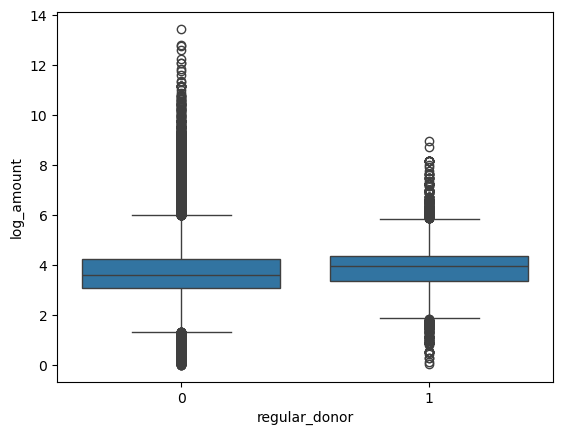

In [230]:
sns.boxplot(x= 'regular_donor',y = 'log_amount', data = donation_converted)

In [231]:
table = pd.crosstab(donation_converted['regular_donor'], donation_converted['Channel_Group'])
chi2, p, dof, expected = chi2_contingency(table)
n = table.values.sum(); k, m = table.shape
V = np.sqrt(chi2/ (n*(min(k,m)-1)))
print(f"Cramer’s V = {V:.3f}")

Cramer’s V = 0.083


In [232]:
table = pd.crosstab(donation_converted['regular_donor'], donation_converted['Payment_Group'])
chi2, p, dof, expected = chi2_contingency(table)
n = table.values.sum(); k, m = table.shape
V = np.sqrt(chi2/ (n*(min(k,m)-1)))
print(f"Cramer’s V = {V:.3f}")

Cramer’s V = 0.068


In [233]:
first_channel_dummy = pd.get_dummies(first_campaign['Channel_Group'], drop_first = True)
first_channel_dummy=first_channel_dummy.astype(int)
idx = first_campaign['SupporterID'].copy()
first_channel_dummy = pd.concat([idx, first_channel_dummy], axis = 1)
first_channel_dummy

,SupporterID,Direct Mail,In-Person,Mass Media,Other media channel,Other/Passive,Telemarketing
0,A-10000004946957,0,0,0,1,0,0
1,A-10000014862260,0,0,0,0,0,0
2,A-10000017862863,0,0,0,0,0,0
3,A-10000119707495,0,0,0,0,0,0
4,A-10000139533932,0,0,0,0,0,0
...,...,...,...,...,...,...,...
537974,O-6010630351404,1,0,0,0,0,0
537975,O-6720630312466,1,0,0,0,0,0
537976,O-7030630342750,1,0,0,0,0,0
537977,O-7090630311792,1,0,0,0,0,0


In [234]:
first_season_dummy = pd.get_dummies(first_campaign['Appeal_Season'], drop_first = True)
first_season_dummy=first_season_dummy.astype(int)
idx = first_campaign['SupporterID'].copy()
first_season_dummy = pd.concat([idx, first_season_dummy], axis = 1)
first_season_dummy

,SupporterID,Christmas,Null,Spring,Tax
0,A-10000004946957,0,1,0,0
1,A-10000014862260,0,1,0,0
2,A-10000017862863,0,1,0,0
3,A-10000119707495,0,1,0,0
4,A-10000139533932,0,1,0,0
...,...,...,...,...,...
537974,O-6010630351404,1,0,0,0
537975,O-6720630312466,0,1,0,0
537976,O-7030630342750,0,0,1,0
537977,O-7090630311792,0,0,0,0


In [235]:
first_activity_dummy = pd.get_dummies(first_campaign['Activity_Group'], drop_first = True)
first_activity_dummy=first_activity_dummy.astype(int)
idx = first_campaign['SupporterID'].copy()
first_activity_dummy = pd.concat([idx, first_activity_dummy], axis = 1)
first_activity_dummy.head()

,SupporterID,Engagement/Stewardship,Gifts,Miscellaneous,Signature Event,Standard Appeal,Unclassified activities
0,A-10000004946957,0,0,0,1,0,0
1,A-10000014862260,0,0,0,0,1,0
2,A-10000017862863,0,0,0,0,1,0
3,A-10000119707495,0,0,0,0,1,0
4,A-10000139533932,0,0,0,0,1,0


In [236]:
first_month_dummy = pd.get_dummies(first_gift_date['Month'], drop_first = True)
first_month_dummy=first_month_dummy.astype(int)
idx = first_campaign['SupporterID'].copy()
first_month_dummy = pd.concat([idx, first_month_dummy], axis = 1)
first_month_dummy.head()

,SupporterID,August,December,February,January,July,June,March,May,November,October,September
0,A-10000004946957,0,0,0,0,0,0,0,0,1,0,0
1,A-10000014862260,0,0,1,0,0,0,0,0,0,0,0
2,A-10000017862863,0,0,0,0,0,0,1,0,0,0,0
3,A-10000119707495,0,0,0,0,0,0,0,0,1,0,0
4,A-10000139533932,0,0,1,0,0,0,0,0,0,0,0


In [237]:
first_donation_channel_dummy = pd.get_dummies(donation_converted['Channel_Group'], drop_first = True)
first_donation_channel_dummy=first_donation_channel_dummy.astype(int)
idx = donation_converted['SupporterID'].copy()
first_donation_channel_dummy = pd.concat([idx, first_donation_channel_dummy], axis = 1)
first_donation_channel_dummy.head()

,SupporterID,Email,Mail,Miscellaneous,Online – 3rd Party,Online – Direct,Online – E-commerce,Phone,Unknown donation channel
0,A-10000004946957,0,0,0,1,0,0,0,0
1,A-10000014862260,0,0,0,0,1,0,0,0
2,A-10000017862863,0,0,0,0,1,0,0,0
3,A-10000119707495,0,0,0,0,1,0,0,0
4,A-10000139533932,0,0,0,0,1,0,0,0


In [238]:
first_payment_dummy = pd.get_dummies(donation_converted['Payment_Group'], drop_first = True)
first_payment_dummy=first_payment_dummy.astype(int)
idx = donation_converted['SupporterID'].copy()
first_payment_dummy = pd.concat([idx, first_payment_dummy], axis = 1)
first_payment_dummy.head()

,SupporterID,Cash,Cheque,Credit Card / Digital Wallet,Direct Debit,Direct Deposit,Other payment,PayPal
0,A-10000004946957,0,0,1,0,0,0,0
1,A-10000014862260,0,0,1,0,0,0,0
2,A-10000017862863,0,0,0,0,0,0,1
3,A-10000119707495,0,0,0,0,0,0,1
4,A-10000139533932,0,0,1,0,0,0,0


# Data

In [239]:
#To train data include only non-converters and converters
data =  donation_effect[((donation_effect['Pre_donation'] >0) & (donation_effect['RGID']>=1)) | ((donation_effect['DonationID']>=1) & (donation_effect['RGID'] == 0))].copy()
to_drop = data[data['DonationID'] == 0]
data = data[~data['SupporterID'].isin(to_drop['SupporterID'])]
data = data[['SupporterID', 'regular_donor']]


In [240]:
converted_established = real_RG_with_outliers_2[real_RG_with_outliers_2['SupporterID'].isin(to_train['SupporterID'])] #Include only converters and non-converters
converted_established = converted_established[['SupporterID', 'Date_Established']].groupby('SupporterID').min() #The soonest established date


last_gift = donations_2[(donations_2['SupporterID'].isin(to_train['SupporterID'])) & (donations_2['RGID'].isna())].copy()
last_gift['converted'] = last_gift['SupporterID'].map(converted_established['Date_Established'])
last_gift['diff'] =  (last_gift['converted']  - last_gift['Gift_Date']).dt.days
pre_donate = last_gift[last_gift['diff'] >= 0 ]

last_gift_date = pre_donate[['SupporterID', 'diff']].groupby('SupporterID').min()
last_gift_date.reset_index(inplace = True)
last_gift = pre_donate.merge(last_gift_date, on = ['SupporterID', 'diff'], how = 'inner')


last_gift = last_gift[['SupporterID', 'diff', 'Gift_Date']]
last_gift.drop_duplicates(inplace = True)

### The RFM data

Here I calculate 4 things: 
1. The R_score which reflects the recency of one's donation to the start date of the campaign
2. The M_score which reflects the total amount one donates within the time window after their first donation
3. The R_mean which reflects the both the recency and the frequency in the sense that it averages the duration of each donations to the start date of the first campaign => more frequent will get the lower score otherwise receive penalty
4. The F score which reflects the number of donations one make within the time window after their first donation

In [241]:
data_donate = donations_2[(donations_2['SupporterID'].isin(data['SupporterID'])) & (donations_2['RGID'].isna())].copy() #Include only non-RG donations from the data
data_donate['first'] = data_donate['SupporterID'].map(first_gift.set_index('SupporterID')['Gift_Date']) #Map the first gift date
data_donate['since_first'] = (data_donate['Gift_Date'] - data_donate['first']).dt.days #Calculate the number of dates since the first donation
data_donate = data_donate[data_donate['since_first'] <= 90] #INclude only donations within 90 since the first gift 

# time_point = first_gift_date.copy()
# time_point['time_point'] = first_gift_date['Gift_Date'] + pd.Timedelta(days = 90)
# time_point.drop(columns = 'Gift_Date', inplace = True)



campaign_start = first_gift.merge(donations_2, on=['SupporterID', 'Gift_Date'], how  = 'left')
campaign_start['Date'] = campaign_start['CampaignID'].map(campaign.set_index('CampaignID')['Start_Date'])
start_date = campaign_start[['CampaignID', 'Date']].groupby('CampaignID').min()
campaign_start.drop_duplicates(subset=['SupporterID'], inplace =True)
campaign_start['Date'] = campaign_start['CampaignID'].map(start_date['Date'])
data_donate['Start_Date'] = data_donate['SupporterID'].map(campaign_start.set_index('SupporterID')['Date'])
data_donate['recency'] = (data_donate['Gift_Date'] - data_donate['Start_Date']).dt.days


duration_gap = data_donate[['SupporterID', 'since_first']].groupby('SupporterID').mean()
recency = data_donate[['SupporterID', 'recency']].groupby('SupporterID').min()
# last_window = data_donate[['SupporterID', 'Gift_Date']].groupby('SupporterID').max()
freq = data_donate[['SupporterID', 'DonationID']].groupby('SupporterID').count() #Number of donations within the time window 
sum_amount = data_donate[['SupporterID', 'Gift_Amount']].groupby('SupporterID').sum() #Averaeg amount of donation within the time window




data['R_score'] =  data['SupporterID'].map(recency['recency'])
data['M_score'] =  data['SupporterID'].map(np.log1p(sum_amount['Gift_Amount'])) #Log transformation
data['F_score'] = data['SupporterID'].map(freq['DonationID'])
data['R_mean'] = data['SupporterID'].map(duration_gap['since_first'])
# data['R_score'] =  data['SupporterID'].map(recency.set_index('SupporterID')['recency'])

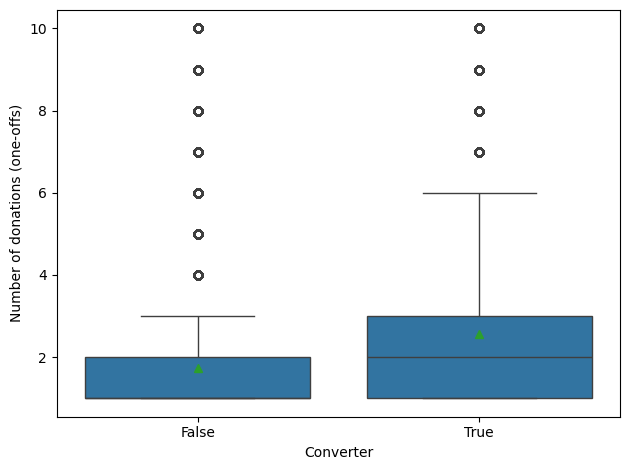

In [242]:
check = donation_effect[(donation_effect['DonationID'] <= 10) & (donation_effect['DonationID'] >= 1)]
sns.boxplot(x='regular_donor',y='DonationID', data=check, showmeans= True)
plt.xlabel('Converter')
plt.ylabel('Number of donations (one-offs)')
plt.tight_layout()

Text(0.5, 0, 'Converters')

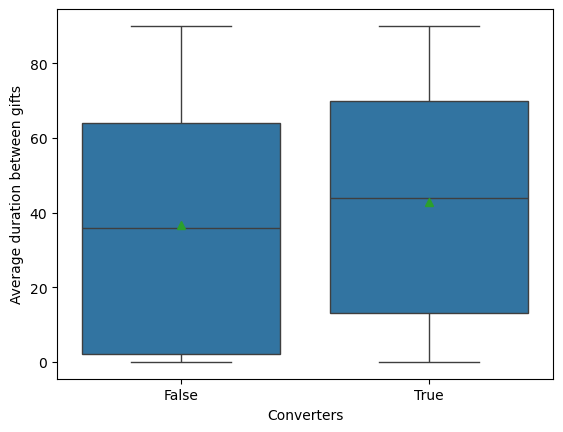

In [243]:
check = data_donate.copy()
check['Donations'] = check['SupporterID'].map(data.set_index('SupporterID')['F_score'])
check = check[check['Donations'] >= 2]
check = check[['SupporterID', 'since_first']].groupby('SupporterID').max()
check.reset_index(inplace =True) 
check['regular_donor'] = check['SupporterID'].map(data.set_index('SupporterID')['regular_donor'])
sns.boxplot(x='regular_donor', y='since_first', data=check, showmeans= True)
plt.ylabel('Average duration between gifts')
plt.xlabel('Converters')

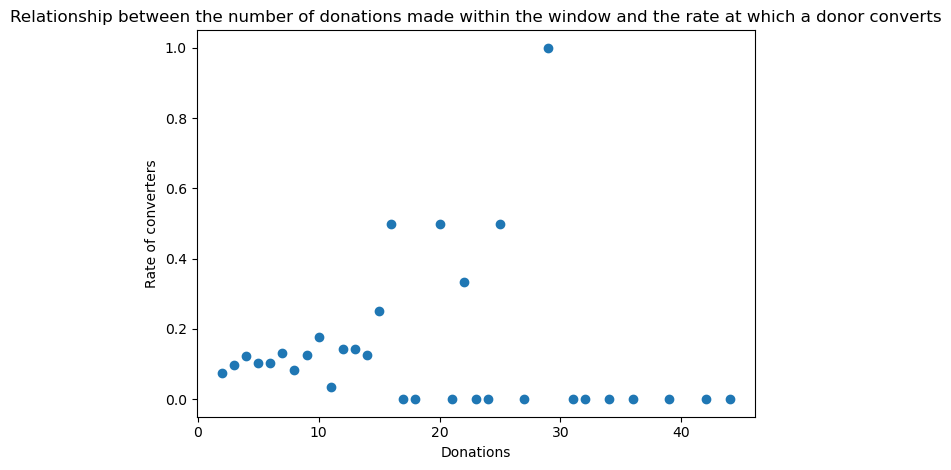

In [244]:
check = data_donate.copy()
check['Donations'] = check['SupporterID'].map(data.set_index('SupporterID')['F_score'])
check = check[(check['Donations'] >= 2) & (check['Donations'] <= 50)]
check['regular_donor'] = check['SupporterID'].map(data.set_index('SupporterID')['regular_donor'])

check_effect = check[['Donations', 'regular_donor']].groupby('Donations').mean()
plt.scatter(check_effect.index, check_effect)
plt.xlabel('Donations')
plt.ylabel('Rate of converters')
plt.title('Relationship between the number of donations made within the window and the rate at which a donor converts')
plt.tight_layout()

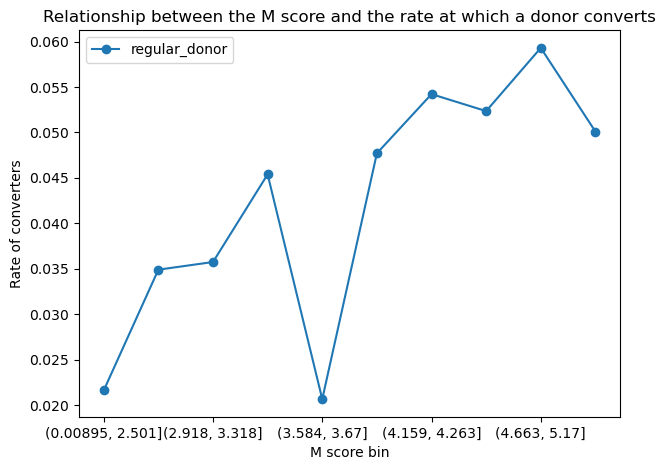

In [245]:
check = data.copy()
check['bin_M_score'] = pd.qcut(check['M_score'], 10) 
check_effect = check[['bin_M_score', 'regular_donor']].groupby('bin_M_score').mean()
check_effect.plot(marker = 'o')
plt.xlabel('M score bin')
plt.ylabel('Rate of converters')
plt.title('Relationship between the M score and the rate at which a donor converts')
plt.tight_layout()

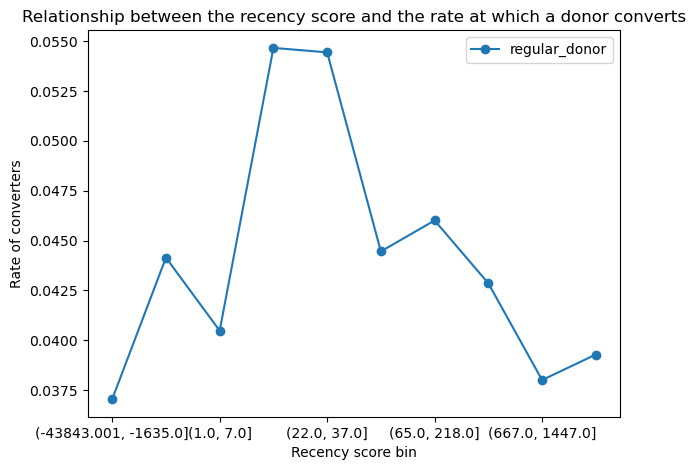

In [246]:
check['bin_recency_score'] = pd.qcut(check['R_score'], 10) 
check_effect = check[['bin_recency_score', 'regular_donor']].groupby('bin_recency_score').mean()
check_effect.plot(marker = 'o')
plt.xlabel('Recency score bin')
plt.ylabel('Rate of converters')
plt.title('Relationship between the recency score and the rate at which a donor converts')
plt.tight_layout()

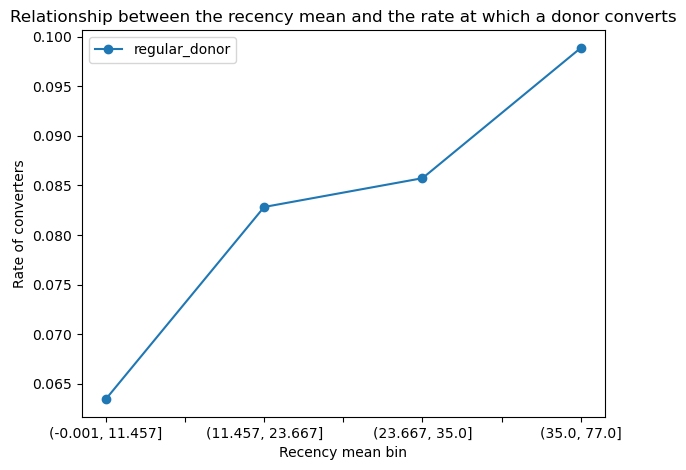

In [247]:
check = check[check['F_score'] >= 2]
check['bin_recency_mean'] = pd.qcut(check['R_mean'], q=5, duplicates = 'drop') 
check_effect = check[['bin_recency_mean', 'regular_donor']].groupby('bin_recency_mean').mean()
check_effect.plot(marker = 'o')
plt.xlabel('Recency mean bin')
plt.ylabel('Rate of converters')
plt.title('Relationship between the recency mean and the rate at which a donor converts')
plt.tight_layout()


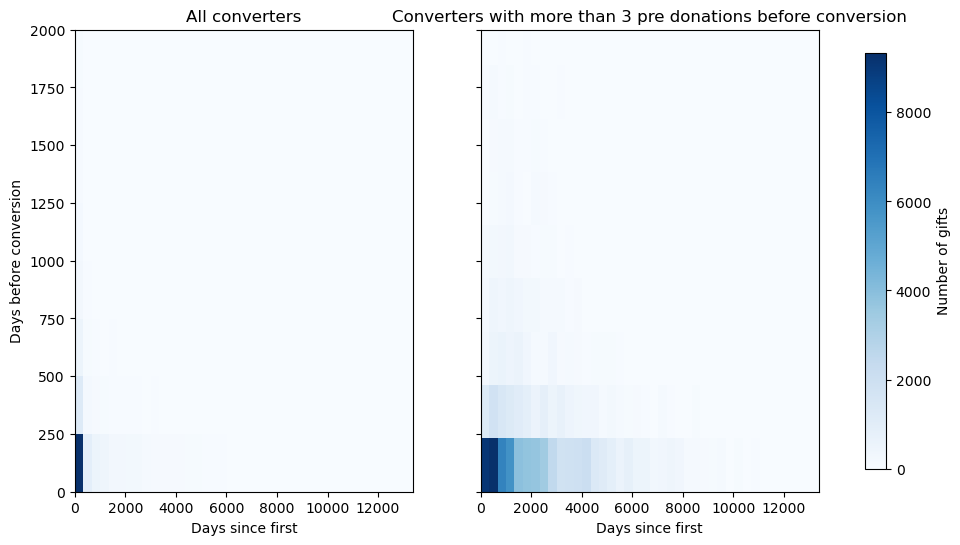

In [248]:
last_gift['first'] = last_gift['SupporterID'].map(first_gift.set_index('SupporterID')['Gift_Date'])
last_gift['since_first'] = (last_gift['Gift_Date'] - last_gift['first']).dt.days
check = last_gift.copy()
check['pre'] = check['SupporterID'].map(donation_effect.set_index('SupporterID')['Pre_donation'])
check_2 = check[check['pre']>= 3]
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# First plot
h0 = ax[0].hist2d(check['since_first'], check['diff'], bins=40, cmap='Blues')
ax[0].set_xlabel('Days since first')
ax[0].set_ylabel('Days before conversion')
ax[0].set_title('All converters')
ax[0].set_ylim(0, 2000)
# Second plot
h1 = ax[1].hist2d(check_2['since_first'], check_2['diff'], bins=40, cmap='Blues')
ax[1].set_xlabel('Days since first')
ax[1].set_title('Converters with more than 3 pre donations before conversion')
ax[1].set_ylim(0, 2000)

# Add colorbar for one of the plots (shared)
cbar = fig.colorbar(h0[3], ax=ax, orientation='vertical', shrink=0.9)
cbar.set_label('Number of gifts')

# plt.tight_layout()
plt.show()

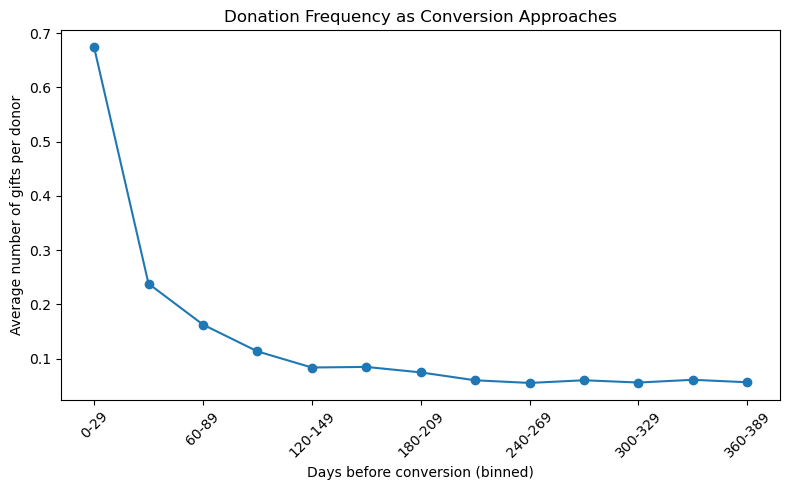

In [249]:
# 1. Compute each supporter’s first conversion date
first_conv = (
    real_RG_with_outliers_2
    .groupby('SupporterID')['Date_Established']
    .min()
    .rename('conversion_date')
)

# 2. Subset all donations for converted supporters and join conversion_date
donations_RG = (
    donations_2[donations_2['SupporterID'].isin(first_conv.index)]
    .copy()
    .assign(
        Gift_Date=pd.to_datetime(donations_2['Gift_Date'])
    )
)
donations_RG = donations_RG.join(first_conv, on='SupporterID')
donations_RG = donations_RG[donations_RG['SupporterID'].isin(to_train['SupporterID'])]
# 3. Compute days before conversion for each gift
donations_RG['days_to_conv'] = (donations_RG['conversion_date'] - donations_RG['Gift_Date']).dt.days
donations_RG = donations_RG[donations_RG['days_to_conv'] >= 0]

# 4. Define bins (e.g., 30-day bins up to 365 days)
max_days = donations_RG['days_to_conv'].max()
bins = list(range(0, min(max_days, 365) + 30, 30))
labels = [(f"{b}-{b+29}") for b in bins[:-1]]

donations_RG['bin'] = pd.cut(donations_RG['days_to_conv'], bins=bins, labels=labels, right=False)

# 5. Count gifts per donor in each bin
gifts_per_bin = (
    donations_RG
    .groupby(['SupporterID', 'bin'])
    .size()
    .reset_index(name='gifts')
)

# 6. Average across donors for each bin
avg_gifts = (
    gifts_per_bin
    .groupby('bin')['gifts']
    .mean()
)

# 7. Plot the trend
plt.figure(figsize=(8, 5))
avg_gifts.plot(marker='o')
plt.xlabel('Days before conversion (binned)')
plt.ylabel('Average number of gifts per donor')
plt.title('Donation Frequency as Conversion Approaches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

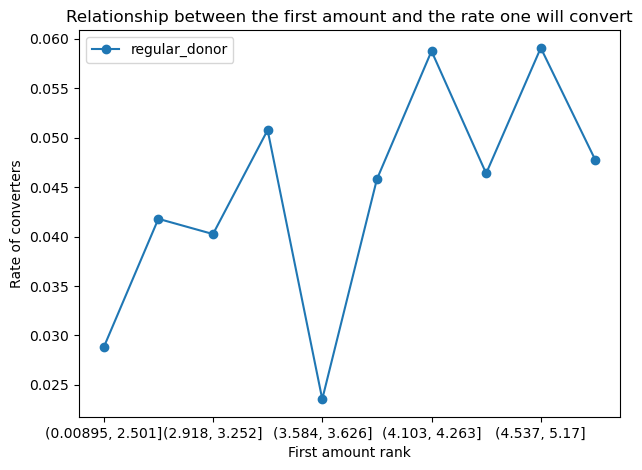

In [250]:
#First amount
donation_converted['bin_amount'] = pd.qcut(donation_converted['log_amount'], q=10)
rates_amount = donation_converted[['bin_amount', 'regular_donor']].groupby('bin_amount').mean()
rates_amount.plot(marker='o')
plt.ylabel('Rate of converters')
plt.xlabel('First amount rank')
plt.title('Relationship between the first amount and the rate one will convert')
plt.tight_layout()

In [251]:
contact_dummy = pd.get_dummies(effect_contact['Contactability'], prefix = 'ctc', drop_first = True)
idx = effect_contact['SupporterID'].copy()
contact_dummy = pd.concat([idx, contact_dummy], axis = 1)
contact_dummy.head()

,SupporterID,ctc_1,ctc_2,ctc_3,ctc_4
0,C-3030020927884,False,False,False,False
3,C-3640021990181,True,False,False,False
5,C-6500022875752,True,False,False,False
8,C-9560022994235,True,False,False,False
19,C-7110036133669,True,False,False,False


In [252]:
postcode_data['young_cube'] = (np.log1p(postcode_data['Young']))**3
postcode_data['school_cube']= postcode_data['School_aged']**3

postcode_data['high_sq'] = postcode_data['High_Income']**2
postcode_data['low_sq']= postcode_data['Low_Income']**2

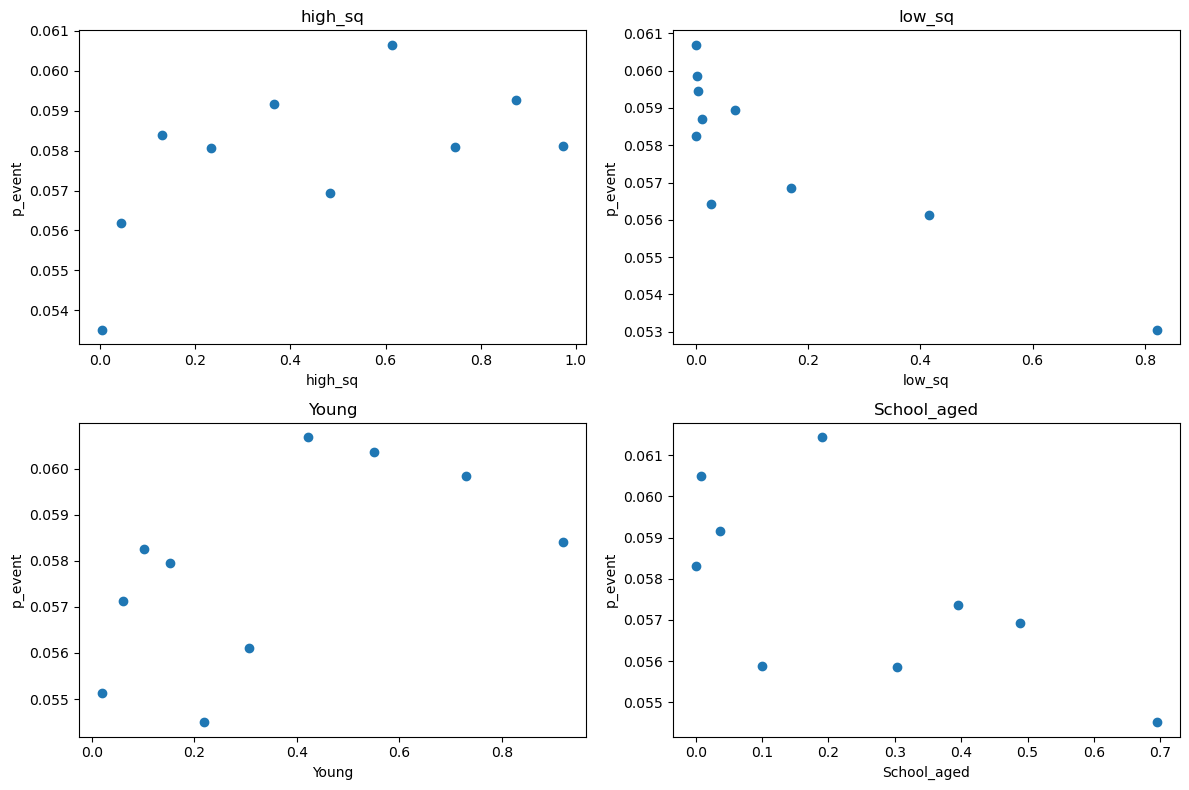

In [253]:
check = postcode_data[postcode_data['SupporterID'].isin(to_train['SupporterID'])].copy()
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes = axes.flatten()
for ax, feat in zip(axes, ['high_sq', 'low_sq', 'Young','School_aged']):
    check['bin'] = pd.qcut(check[feat], 10, duplicates='drop')
    grp = check.groupby('bin').agg(
        mid=(feat,'mean'),
        rate=('regular_donor','mean')
    ).reset_index()
    ax.scatter(grp['mid'], grp['rate'])
    ax.set_title(feat)
    ax.set_xlabel(feat); ax.set_ylabel('p_event')

plt.tight_layout()
plt.show()

## Final dataset

In [324]:
#To train data include only non-converters and converters
data =  donation_effect[((donation_effect['Pre_donation'] >0) & (donation_effect['RGID']>=1)) | ((donation_effect['DonationID']>=1) & (donation_effect['RGID'] == 0))].copy()
to_drop = data[data['DonationID'] == 0]
data = data[~data['SupporterID'].isin(to_drop['SupporterID'])]
data = data[['SupporterID', 'regular_donor']]


In [408]:
data.values

array([['A-10000004946957', False],
       ['A-10000014862260', False],
       ['A-10000017862863', False],
       ...,
       ['O-7030630342750', False],
       ['O-7090630311792', False],
       ['O-8390630335520', False]], dtype=object)

In [325]:
data_donate = donations_2[(donations_2['SupporterID'].isin(data['SupporterID'])) & (donations_2['RGID'].isna())].copy() #Include only non-RG donations from the data
data_donate['first'] = data_donate['SupporterID'].map(first_gift.set_index('SupporterID')['Gift_Date']) #Map the first gift date
data_donate['since_first'] = (data_donate['Gift_Date'] - data_donate['first']).dt.days #Calculate the number of dates since the first donation
data_donate = data_donate[data_donate['since_first'] <= 90] #INclude only donations within 90 since the first gift 

# time_point = first_gift_date.copy()
# time_point['time_point'] = first_gift_date['Gift_Date'] + pd.Timedelta(days = 90)
# time_point.drop(columns = 'Gift_Date', inplace = True)



campaign_start = first_gift.merge(donations_2, on=['SupporterID', 'Gift_Date'], how  = 'left')
campaign_start['Date'] = campaign_start['CampaignID'].map(campaign.set_index('CampaignID')['Start_Date'])
start_date = campaign_start[['CampaignID', 'Date']].groupby('CampaignID').min()
campaign_start.drop_duplicates(subset=['SupporterID'], inplace =True)
campaign_start['Date'] = campaign_start['CampaignID'].map(start_date['Date'])
data_donate['Start_Date'] = data_donate['SupporterID'].map(campaign_start.set_index('SupporterID')['Date'])
data_donate['recency'] = (data_donate['Gift_Date'] - data_donate['Start_Date']).dt.days


duration_gap = data_donate[['SupporterID', 'since_first']].groupby('SupporterID').mean()
recency = data_donate[['SupporterID', 'recency']].groupby('SupporterID').min()
# last_window = data_donate[['SupporterID', 'Gift_Date']].groupby('SupporterID').max()
freq = data_donate[['SupporterID', 'DonationID']].groupby('SupporterID').count() #Number of donations within the time window 
sum_amount = data_donate[['SupporterID', 'Gift_Amount']].groupby('SupporterID').sum() #Averaeg amount of donation within the time window




data['R_score'] =  data['SupporterID'].map(recency['recency'])
data['M_score'] =  data['SupporterID'].map(np.log1p(sum_amount['Gift_Amount'])) #Log transformation
data['F_score'] = data['SupporterID'].map(freq['DonationID'])
data['R_mean'] = data['SupporterID'].map(duration_gap['since_first'])
# data['R_score'] =  data['SupporterID'].map(recency.set_index('SupporterID')['recency'])

In [326]:
postcode_train = postcode_data.copy()

postcode_train = postcode_train[['SupporterID',  'High_Income', 'Low_Income' , 'Young', 'School_aged', 'Postcode']]

data = data.merge(postcode_train, on = 'SupporterID', how = 'left') 
data = data.merge(first_channel_dummy, on = 'SupporterID', how ='left')
# data = data.merge(first_season_dummy, on = 'SupporterID', how ='left')
data = data.merge(first_activity_dummy, on = 'SupporterID', how ='left')
data = data.merge(first_month_dummy, on = 'SupporterID', how ='left')
data = data.merge(first_donation_channel_dummy, on = 'SupporterID', how ='left')
data = data.merge(first_payment_dummy, on = 'SupporterID', how ='left')


counts = data.groupby('Postcode').size()

data['weight'] = 1/data['Postcode'].map(counts)
data['contact_index'] = data['SupporterID'].map(contact_info.set_index('SupporterID')['Contactability'])
# data['log_first'] = data['SupporterID'].map(donation_converted.set_index('SupporterID')['log_amount'])
data = data[~data['SupporterID'].isin(to_exclude)]


In [327]:
data['regular_donor'] = data['regular_donor'].astype(int)

In [328]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)


data = data.copy()                   # work on a fresh copy
data['Area_Score'] = np.nan          # placeholder

k = 50                               # smoothing parameter

for train_idx, val_idx in kf.split(data):
    # 1) Split indices
    df_in  = data.iloc[train_idx]
    df_oof = data.iloc[val_idx]

    # 2) Global mean on the in-fold
    global_mean = df_in['regular_donor'].mean()

    # 3) Local (category) stats on the in-fold
    stats = (
        df_in
        .groupby('Postcode')['regular_donor']
        .agg(['mean','count'])
        .rename(columns={'mean':'y','count':'n'})
    )
    # 4) Smoothed target encoding per category
    stats['te'] = (stats['n']*stats['y'] + k*global_mean) / (stats['n'] + k)

    # 5) Map that encoding onto the held-out rows
    data.iloc[val_idx, data.columns.get_loc('Area_Score')] = (
        df_oof['Postcode']
        .map(stats['te']) )

In [329]:
data.drop(columns= ['SupporterID', 'Postcode', 'weight'], inplace = True)

In [260]:
data

,regular_donor,R_score,M_score,F_score,R_mean,High_Income,Low_Income,Young,School_aged,Direct Mail,...,Unknown donation channel,Cash,Cheque,Credit Card / Digital Wallet,Direct Debit,Direct Deposit,Other payment,PayPal,contact_index,Area_Score
0,0,27.0,4.354141,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,0,48.0,7.244942,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
2,0,60.0,4.222445,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
3,0,675.0,3.583519,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
4,0,5.0,5.190175,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411068,0,371.0,6.117877,1.0,0.0,NaN,NaN,NaN,NaN,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
411069,0,331.0,3.979682,1.0,0.0,NaN,NaN,NaN,NaN,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
411070,0,31.0,6.265301,1.0,0.0,NaN,NaN,NaN,NaN,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
411071,0,186.0,4.948760,1.0,0.0,NaN,NaN,NaN,NaN,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN


In [330]:
data.dropna(inplace = True)
counts = data.groupby('regular_donor').size()

data['weight'] = 1/data['regular_donor'].map(counts)

In [172]:
# imputer = IterativeImputer(max_iter = 15, random_state = 0, initial_strategy='median', verbose =3)
# data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)
# counts = data.groupby('regular_donor').size()

# data['weight'] = 1/data['regular_donor'].map(counts)

In [331]:
y = data['regular_donor']
x = data[data.columns.difference(['regular_donor'])]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)


train_weight = x_train['weight']
x_train = x_train[x_train.columns.difference(['weight'])]

test_weight = x_test['weight']
x_test= x_test[x_test.columns.difference(['weight'])]


# Models

In [ ]:
model = tree.DecisionTreeClassifier( class_weight = 'balanced', random_state= 1)
# model.fit(x_train, y_train)

param_grid = {'max_depth': np.arange(4, 20, 1) }#, 'min_samples_split': [2,5,10], 'min_samples_leaf': [1,2,5]}

model_cv = GridSearchCV(model, param_grid, scoring = 'average_precision', cv = 5, verbose = 3, n_jobs =-1, error_score='raise')
model_cv.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [176]:
y_pred = model_cv.predict(x_test)

In [177]:
best = model_cv.best_estimator_
print(best)

DecisionTreeClassifier(class_weight='balanced', max_depth=np.int64(7),
                       random_state=1)


In [178]:
print(classification_report(
    y_test, y_pred, 
))

              precision    recall  f1-score   support

           0       0.97      0.78      0.86     54694
           1       0.14      0.60      0.23      3320

    accuracy                           0.77     58014
   macro avg       0.55      0.69      0.55     58014
weighted avg       0.92      0.77      0.83     58014



In [179]:
y_proba = model_cv.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [180]:
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.3f}")

AUC: 0.732


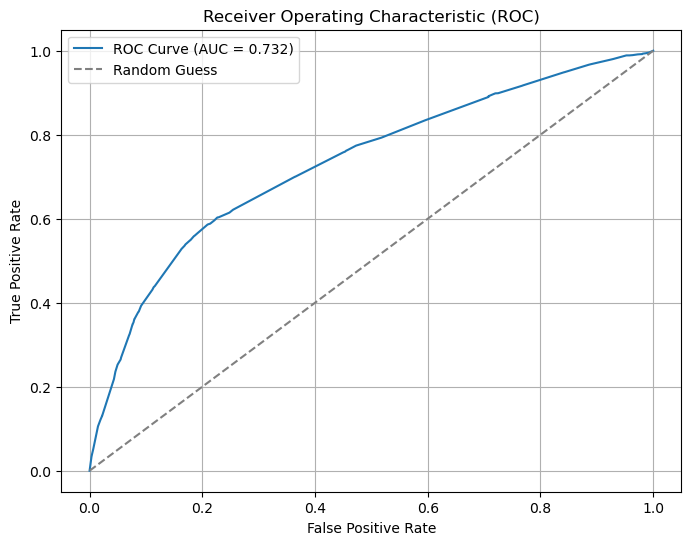

In [181]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid(True)
plt.show()

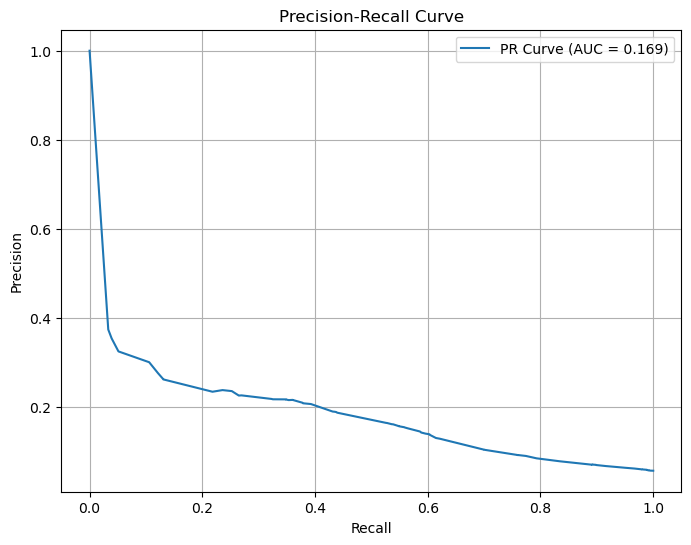

[CV 4/5] END .......................max_depth=5;, score=0.157 total time=   1.1s
[CV 2/5] END .......................max_depth=8;, score=0.164 total time=   1.6s
[CV 4/5] END ......................max_depth=11;, score=0.153 total time=   1.9s
[CV 2/5] END ......................max_depth=14;, score=0.136 total time=   2.5s
[CV 1/5] END ......................max_depth=17;, score=0.121 total time=   3.0s
[CV 2/5] END .......................max_depth=4;, score=0.155 total time=   1.0s
[CV 2/5] END .......................max_depth=7;, score=0.171 total time=   1.4s
[CV 3/5] END ......................max_depth=10;, score=0.161 total time=   1.9s
[CV 5/5] END ......................max_depth=13;, score=0.139 total time=   2.3s
[CV 5/5] END ......................max_depth=16;, score=0.119 total time=   2.6s
[CV 1/5] END .......................max_depth=5;, score=0.154 total time=   1.1s
[CV 1/5] END .......................max_depth=8;, score=0.162 total time=   1.5s
[CV 2/5] END ...............

In [182]:
# Step 1: Get predicted probabilities for class 1
y_proba = model_cv.predict_proba(x_test)[:, 1]

# Step 2: Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Step 3: Compute PR AUC (also called average precision)
pr_auc = average_precision_score(y_test, y_proba)
# print(f"PR AUC (Average Precision): {pr_auc:.3f}")

# Step 4: Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [264]:
# random_forest = RandomForestClassifier( random_state= 0)
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': np.arange(4, 22, 1) , 'max_features': [0.5, None], 'n_estimators': np.arange(100, 500, 100)}

# forest_cv = RandomizedSearchCV(random_forest, param_grid, n_iter = 50, scoring = 'average_precision', cv = 5,  random_state = 0, verbose = 3)
# forest_cv.fit(x_train, y_train)

In [341]:

param_grid = {'max_depth': np.arange(8, 22, 2) , 'max_features': [0.6, 1], 'n_estimators': np.arange(100, 600, 100),}
def tune_rf_oob_with_early_stop(X, y, param_grid, random_state=0, patience=5, min_delta=1e-4):
  
    combos = list(product(
        param_grid['max_depth'],
        param_grid['max_features'],
        param_grid['n_estimators']
    ))
    
    results = []
    best_score = -np.inf
    best_params = None
    no_improve_count = 0

    for idx, (max_depth, max_features, n_estimators) in enumerate(combos, 1):
        # Early stopping check
        if no_improve_count >= patience:
            print(f"Early stopping: stopped after {idx-1} combos; "
                  f"{patience} consecutive with <{min_delta} improvement.")
            break

        # Train with OOB
        rf = RandomForestClassifier(
            max_depth=int(max_depth),
            max_features=max_features,
            n_estimators=int(n_estimators),
            oob_score=True,
            class_weight='balanced',
            bootstrap=True,
            random_state=random_state,
            n_jobs=1,
            verbose=0
        )
        rf.fit(X, y)
        
        # Compute OOB average precision
        oob_proba = rf.oob_decision_function_[:, 1]
        oob_ap = average_precision_score(y, oob_proba)

        # Record result
        results.append({
            'max_depth': max_depth,
            'max_features': max_features,
            'n_estimators': n_estimators,
            'oob_avg_precision': oob_ap
        })

        # Check improvement
        improvement = oob_ap - best_score
        if improvement > min_delta:
            best_score = oob_ap
            best_params = {
                'max_depth': max_depth,
                'max_features': max_features,
                'n_estimators': n_estimators
            }
            no_improve_count = 0
        else:
            no_improve_count += 1

    df_results = pd.DataFrame(results)
    return df_results, best_params, best_score


In [343]:
table, params, best_score = tune_rf_oob_with_early_stop(x_train, y_train, param_grid)

NameError: name 'product' is not defined

In [221]:
best_score

np.float64(0.18325377378315333)

In [265]:
forest_cv = RandomForestClassifier(max_depth = 8, max_features = 0.7, n_estimators = 400, class_weight = 'balanced')
forest_cv.fit(x_train, y_train)
y_pred = forest_cv.predict(x_test)


In [202]:
print(classification_report(
    y_test, y_pred, 
))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     54694
           1       0.15      0.57      0.24      3320

    accuracy                           0.79     58014
   macro avg       0.56      0.69      0.56     58014
weighted avg       0.92      0.79      0.84     58014



In [132]:
best = forest_cv.best_estimator_
print(best)

CUMLRFWrapper(max_depth=np.int64(20), max_features=0.7,
              n_estimators=np.int64(400))


In [203]:
y_proba = forest_cv.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [204]:
# Try different thresholds (e.g. 0.3, 0.25, 0.2)
threshold = 0.72
y_pred_adjusted = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     54694
           1       0.22      0.33      0.26      3320

    accuracy                           0.90     58014
   macro avg       0.59      0.63      0.60     58014
weighted avg       0.92      0.90      0.91     58014



In [205]:
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.3f}")

AUC: 0.744


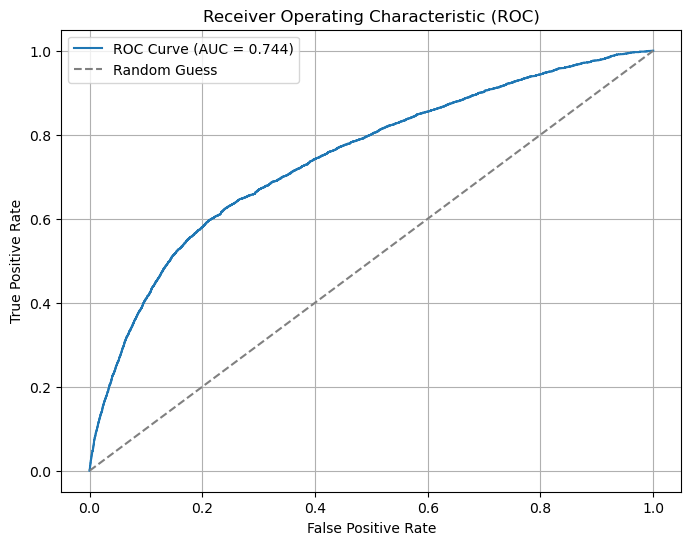

In [206]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid(True)
plt.show()

PR AUC (Average Precision): 0.182


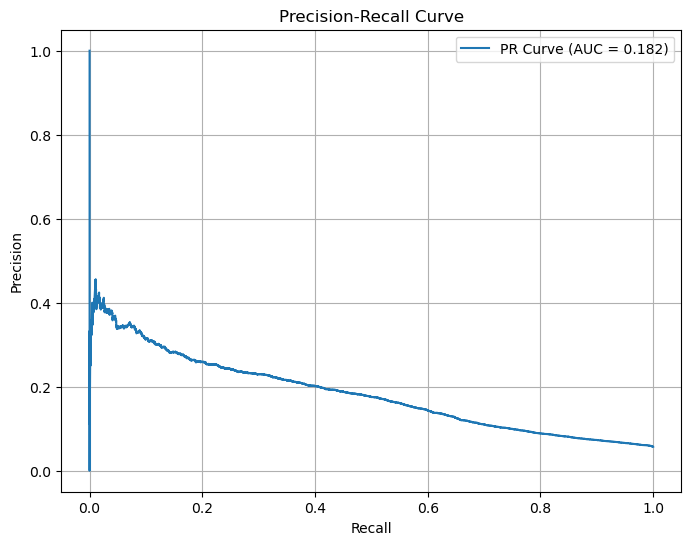

In [207]:
# Step 1: Get predicted probabilities for class 1
y_proba = forest_cv.predict_proba(x_test)[:, 1]

# Step 2: Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Step 3: Compute PR AUC (also called average precision)
pr_auc = average_precision_score(y_test, y_proba)
print(f"PR AUC (Average Precision): {pr_auc:.3f}")

# Step 4: Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [266]:
import tensorflow as tf

2025-05-19 15:52:27.235019: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 15:52:27.502335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747633947.598899  132042 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747633947.629783  132042 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747633947.864315  132042 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [267]:
tf.keras.utils.set_random_seed(0)

In [142]:
# tf.debugging.set_log_device_placement(False)

In [268]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers import Adam

In [269]:


from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)

# Convert to dictionary
class_weights = {0: class_weights[0], 1: class_weights[1]}

# 1) Define your EarlyStopping
early_stop = EarlyStopping(
    monitor       = "val_AUC",    
    min_delta     = 1e-4,          # smallest change to qualify as “improvement”
    patience      = 10,             # how many epochs with no improvement before stopping
    mode          = "max",         # "min" because we’re monitoring loss; use "max" for AUC
    restore_best_weights = True    # roll back to the weights from the epoch with the best monitored value
)



In [270]:
x_sample, x_sample_test, y_sample, y_sample_test = train_test_split(x_train, y_train, test_size = 0.4, random_state = 0)

In [271]:
x_sample_test

,Area_Score,August,Cash,Cheque,Credit Card / Digital Wallet,December,Direct Debit,Direct Deposit,Direct Mail,Email,...,R_score,School_aged,September,Signature Event,Standard Appeal,Telemarketing,Unclassified activities,Unknown donation channel,Young,contact_index
212578,0.054077,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,13.0,0.330852,0.0,0.0,1.0,0.0,0.0,1.0,0.121397,1.0
27209,0.043035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.0,0.519705,0.0,0.0,1.0,0.0,0.0,1.0,0.225780,1.0
339326,0.044994,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,616.0,0.250820,0.0,0.0,1.0,0.0,0.0,0.0,0.172211,3.0
366130,0.052376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1219.0,0.384845,0.0,0.0,1.0,0.0,0.0,0.0,0.239273,0.0
34051,0.033495,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,662.0,0.000261,0.0,0.0,1.0,0.0,0.0,1.0,0.810462,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257807,0.038844,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,22.0,0.519705,0.0,0.0,1.0,0.0,0.0,1.0,0.225780,3.0
154029,0.042929,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-945.0,0.066197,0.0,0.0,0.0,0.0,0.0,1.0,0.128209,1.0
328574,0.073631,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,372.0,0.000279,0.0,0.0,1.0,0.0,0.0,0.0,0.748281,4.0
305042,0.055521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,0.383470,0.0,0.0,1.0,0.0,0.0,0.0,0.241786,1.0


In [272]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold

In [160]:
import math
def _generate_layer_configs():
    """Returns a list of hidden‐layer size lists for 3‐ and 4‐layer nets."""
    configs = []
    # 3 hidden layers
    # for first in [128, 64]:
    #     second = math.ceil(first // 2)
    #     max_last = math.ceil(second // 2)
    #     for last in [32, 16, 8]:
    #         if last <= max_last:
    #             configs.append([first, second, last])
    # 4 hidden layers
    for first in [256, 128, 64]:
        second = first // 2
        third  = second // 2
        max_last = third // 2
        for last in [32, 16, 8]:
            if last <= max_last:
                configs.append([first, second, third, last])
    return configs

def _build_model(n_features, layer_sizes, dropout_rate, lr, momentum): #, weight_decay):
    """Constructs & compiles a Keras model with the given hyperparameters."""
    
    m = Sequential()
    m.add(Input(shape=(n_features,)))
    for i, units in enumerate(layer_sizes):
        # m.add(Dense(units,
        #             activation='relu',
        #             kernel_regularizer=l2(weight_decay)))
        m.add(Dense(units,
                    activation='relu'))
        if i < 2:  # dropout after layers 0 and 1 only
            m.add(Dropout(dropout_rate))
    m.add(Dense(1, activation='sigmoid'))
    # use Adam with beta_1=momentum
    opt = Adam(learning_rate=lr, beta_1=momentum)
    m.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return m

def tune_neural_network_cv(
    X, y,
    class_weight: dict,
    early_stop: tf.keras.callbacks.Callback,
    n_splits: int = 5,
    batch_size: int = 32,
    epochs: int = 100,
    verbose = 1
):

    X_arr = np.array(X)
    y_arr = np.array(y)
    n_features = X_arr.shape[1]
    # skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    layer_configs  = _generate_layer_configs()
    dropout_rates  = [0.0, 0.2]
    lrs            = [1e-3, 5e-4]
    momentums      = [0.5, 0.8, 0.9]
    # weight_decays  = [0, 5e-4, 1e-3]

    records = []
    best_score = -np.inf
    best_params = None

    try: 
    
        for layers in layer_configs:
            for drop in dropout_rates:
                for lr in lrs:
                    for mom in momentums:
                        # for wd in weight_decays:
                        fold_aucs = []
                            # CV loop
                            # for train_idx, val_idx in skf.split(X_arr, y_arr):
                            #     X_tr, X_val = X_arr[train_idx], X_arr[val_idx]
                            #     y_tr, y_val = y_arr[train_idx], y_arr[val_idx]

                        #, wd

                        model = _build_model(
                            n_features, layers, drop, lr, mom 
                        )
                        history = model.fit(
                            X, y,
                            # validation_data=(X_val, y_val),
                            validation_split = 0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            class_weight=class_weight,
                            callbacks=[early_stop],
                            verbose= verbose
                        )
                        # take the best val_auc achieved
                        best_val_auc = max(history.history['val_AUC'])
                        fold_aucs.append(best_val_auc)

                    mean_auc = float(np.mean(fold_aucs))
                    records.append({
                        'layers':       layers,
                        'dropout':      drop,
                        'learning_rate':lr,
                        'momentum':     mom,
                        # 'weight_decay': wd,
                        'mean_val_auc': mean_auc
                    })

                    if mean_auc > best_score:
                        best_score = mean_auc
                        best_params = {
                            'layers':       layers,
                            'dropout':      drop,
                            'learning_rate':lr,
                            'momentum':     mom,
                            # 'weight_decay': wd
                        }
                        best_model = model

    except KeyboardInterrupt:
        print(f"\nInterrupted—returning {len(records)} results so far.")
        
    df_results = pd.DataFrame(records)



    
    if best_model is not None:
        best_model.save('best_so_far.h5')
    



    
    return df_results, best_params, best_score

In [161]:
df_res, best_params, best_score = tune_neural_network_cv(
    x_sample_test, y_sample_test,
    class_weight=class_weights,
    early_stop=[early_stop],
    n_splits=5,
    batch_size=32,
    epochs=100
)


I0000 00:00:1747495907.218803     567 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/100


I0000 00:00:1747495908.866828    1106 service.cc:152] XLA service 0x7fa2f00038e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747495908.866855    1106 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-05-18 01:31:48.907212: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747495909.107513    1106 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-05-18 01:31:50.052709: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_497', 32 bytes spill stores, 32 bytes spill loads

2025-05-18 01:31:50.088678: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion

  21/2611 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.4733 - loss: 8.0206    

I0000 00:00:1747495911.648501    1106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2583/2611 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5175 - loss: 1.5191

2025-05-18 01:31:57.127390: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 4 bytes spill stores, 4 bytes spill loads

2025-05-18 01:31:57.926774: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_497', 32 bytes spill stores, 32 bytes spill loads

2025-05-18 01:31:58.090926: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 12 bytes spill stores, 12 bytes spill loads

2025-05-18 01:31:58.136886: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_497', 32 bytes spill stores, 32 bytes spill loads



2611/2611 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - AUC: 0.5177 - loss: 1.5129 - val_AUC: 0.5754 - val_loss: 0.6953
Epoch 2/100
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.5677 - loss: 0.6796 - val_AUC: 0.5770 - val_loss: 0.6476
Epoch 3/100
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.5757 - loss: 0.6718 - val_AUC: 0.5695 - val_loss: 0.6545
Epoch 4/100
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.5826 - loss: 0.6689 - val_AUC: 0.5857 - val_loss: 0.6375
Epoch 5/100
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.5974 - loss: 0.6685 - val_AUC: 0.6026 - val_loss: 0.6419
Epoch 6/100
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.6089 - loss: 0.6594 - val_AUC: 0.5994 - val_loss: 0.6906
Epoch 7/100
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.6060 - loss: 0.8820 - val_AUC: 0.6063 - val_loss: 0.6527
Epoch 8/100
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.6127 - loss: 0.6601 - val_AUC: 0.5969 - val_loss: 0.6457
Epoch 9/100
2611/2611 ━━━━━━━━━━━━━━━━━━━━ 


Interrupted—returning 16 results so far.


In [162]:
print("Best mean VAL AUC:", best_score)
print("Best hyperparameters:", best_params)
# Inspect top results:
print(df_res.sort_values('mean_val_auc', ascending=False).head())

Best mean VAL AUC: 0.6695652604103088
Best hyperparameters: {'layers': [128, 64, 32, 16], 'dropout': 0.0, 'learning_rate': 0.001, 'momentum': 0.9}
                layers  dropout  learning_rate  momentum  mean_val_auc
12   [128, 64, 32, 16]      0.0         0.0010       0.9      0.669565
13   [128, 64, 32, 16]      0.0         0.0005       0.9      0.669164
3   [256, 128, 64, 32]      0.2         0.0005       0.9      0.667523
15   [128, 64, 32, 16]      0.2         0.0005       0.9      0.656615
0   [256, 128, 64, 32]      0.0         0.0010       0.9      0.654942


In [165]:
df_res.sort_values('mean_val_auc', ascending = False)

,layers,dropout,learning_rate,momentum,mean_val_auc
12,"[128, 64, 32, 16]",0.0,0.0010,0.9,0.669565
13,"[128, 64, 32, 16]",0.0,0.0005,0.9,0.669164
3,"[256, 128, 64, 32]",0.2,0.0005,0.9,0.667523
15,"[128, 64, 32, 16]",0.2,0.0005,0.9,0.656615
0,"[256, 128, 64, 32]",0.0,0.0010,0.9,0.654942
1,"[256, 128, 64, 32]",0.0,0.0005,0.9,0.652391
2,"[256, 128, 64, 32]",0.2,0.0010,0.9,0.650264
14,"[128, 64, 32, 16]",0.2,0.0010,0.9,0.650038
5,"[256, 128, 64, 16]",0.0,0.0005,0.9,0.644092
9,"[256, 128, 64, 8]",0.0,0.0005,0.9,0.641482


In [351]:
neural = tf.keras.Sequential()
n_features = x_train.shape[1]


neural.add(tf.keras.layers.Input(shape=(n_features,)))
neural.add(tf.keras.layers.Dense(256, activation = 'relu'))
neural.add(tf.keras.layers.Dropout(0.1))
neural.add(tf.keras.layers.Dense(128, activation = 'relu'))
neural.add(tf.keras.layers.Dropout(0.1))
 # layers.BatchNormalization(),
 #    layers.Activation('relu'),
neural.add(tf.keras.layers.Dense(64, activation = 'relu'))
neural.add(tf.keras.layers.Dense(32, activation = 'relu'))
neural.add(tf.keras.layers.Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate = 0.001,  beta_1 = 0.8)
neural.compile(loss='binary_crossentropy', optimizer= optimizer , metrics=['AUC'])


I0000 00:00:1747580203.651605  121838 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5364 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [352]:
neural.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks = [early_stop], class_weight = class_weights)

Epoch 1/100


I0000 00:00:1747580210.296985  124877 service.cc:152] XLA service 0x7fd1bc01d0c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747580210.297011  124877 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-05-19 00:56:50.332268: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747580210.521792  124877 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-05-19 00:56:51.036637: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_215', 12 bytes spill stores, 12 bytes spill loads

2025-05-19 00:56:51.472301: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion

  76/6527 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.5589 - loss: 5.4189   

I0000 00:00:1747580212.721590  124877 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6509/6527 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5692 - loss: 1.1039 

2025-05-19 00:57:05.905664: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_215', 12 bytes spill stores, 12 bytes spill loads

2025-05-19 00:57:06.218745: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_215', 4 bytes spill stores, 4 bytes spill loads



6527/6527 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.5692 - loss: 1.1030 - val_AUC: 0.5871 - val_loss: 0.7520
Epoch 2/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.5971 - loss: 0.6754 - val_AUC: 0.6108 - val_loss: 0.6252
Epoch 3/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.6296 - loss: 0.6956 - val_AUC: 0.6345 - val_loss: 0.6954
Epoch 4/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.6464 - loss: 0.6495 - val_AUC: 0.6405 - val_loss: 0.6740
Epoch 5/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.6470 - loss: 0.6508 - val_AUC: 0.6567 - val_loss: 0.6222
Epoch 6/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.6518 - loss: 0.6496 - val_AUC: 0.6442 - val_loss: 0.6729
Epoch 7/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.6539 - loss: 0.6470 - val_AUC: 0.6609 - val_loss: 0.6488
Epoch 8/100
6527/6527 ━━━━━━━━━━━━━━━━━━━━ 924s 142ms/step - AUC: 0.6632 - loss: 0.6426 - val_AUC: 0.6724 - val_loss: 0.6571
Epoch 9/100
6527/6527 ━━━━━━━━━━━

In [355]:
y_proba = neural.predict(x_test)[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
auc_score

1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


np.float64(0.6808478199190149)

1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 976us/step
PR AUC (Average Precision): 0.132


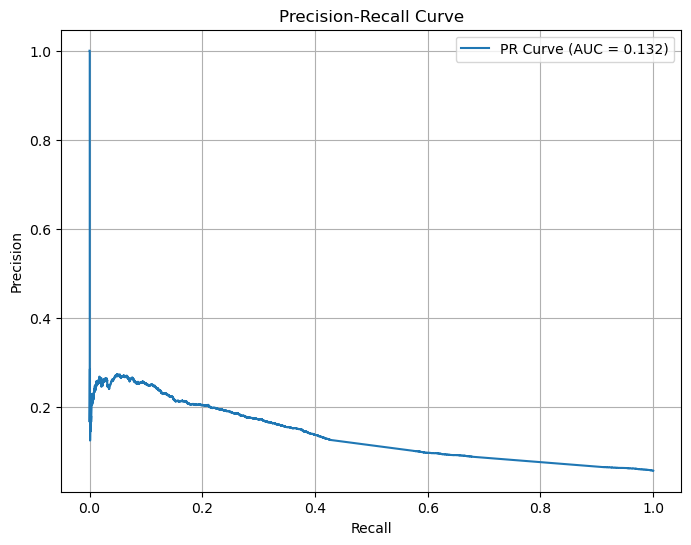

In [356]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Step 1: Get predicted probabilities for class 1
y_proba = neural.predict(x_test)[:, 0]

# Step 2: Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Step 3: Compute PR AUC (also called average precision)
pr_auc = average_precision_score(y_test, y_proba)
print(f"PR AUC (Average Precision): {pr_auc:.3f}")

# Step 4: Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# XGboost

In [183]:
from xgboost import XGBClassifier

In [184]:
import cudf

In [185]:
gdf_train = cudf.DataFrame.from_pandas(x_train)
gdf_test  = cudf.DataFrame.from_pandas(x_test)

In [186]:
scale = data[data['regular_donor'] == 0].shape[0]/data[data['regular_donor'] ==1].shape[0]
# param_grid = {booster = 'gbtree',
# eta= 0.2, device = 'cuda', scale_pos_weight= scale, max_depth: np.arange(6, 20, 1) , 
# max_delta_step: np.arange(0, 6, 1), max_leaves: np.arange(32, 64, 2)}
# force the DMatrix onto cuda:0
# dtrain = xgboost.DMatrix(x_train, label=y_train)
# dtest  = xgboost.DMatrix(x_test,  label=y_test)

param_grid = {
  "booster": ["gbtree"],
  "device": ["cuda"], 
  "eta": [0.1, 0.15, 0.2],
  "scale_pos_weight": [scale],             # your precomputed ~21.7
  "max_depth": np.arange(6, 20),           # narrower focus
  "max_delta_step": [0, 1, 3],              # only values that matter
  "subsample": [0.6, 0.8, 1.0],
  "colsample_bytree": [0.6, 0.8, 1.0],
  "min_child_weight": [1, 5, 10]
}


xg = XGBClassifier()
xg_cv = RandomizedSearchCV(xg, param_grid, n_iter= 100,  scoring = 'average_precision', cv = 5, 
                           verbose = 3,  error_score='raise', random_state= 032)
xg_cv.fit(gdf_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END booster=gbtree, colsample_bytree=1.0, device=cuda, eta=0.15, max_delta_step=1, max_depth=10, min_child_weight=1, scale_pos_weight=16.316518416810936, subsample=1.0;, score=0.156 total time=   1.8s
[CV 2/5] END booster=gbtree, colsample_bytree=1.0, device=cuda, eta=0.15, max_delta_step=1, max_depth=10, min_child_weight=1, scale_pos_weight=16.316518416810936, subsample=1.0;, score=0.167 total time=   1.2s
[CV 3/5] END booster=gbtree, colsample_bytree=1.0, device=cuda, eta=0.15, max_delta_step=1, max_depth=10, min_child_weight=1, scale_pos_weight=16.316518416810936, subsample=1.0;, score=0.168 total time=   1.2s
[CV 4/5] END booster=gbtree, colsample_bytree=1.0, device=cuda, eta=0.15, max_delta_step=1, max_depth=10, min_child_weight=1, scale_pos_weight=16.316518416810936, subsample=1.0;, score=0.167 total time=   1.2s
[CV 5/5] END booster=gbtree, colsample_bytree=1.0, device=cuda, eta=0.15, max_delta_step=1, max_de

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           i...
                                           num_parallel_tree=None, ...),
                   n_iter=50,
                   param_distributions={'booster': ['gbtree'],
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                                        'device': ['cuda'],
                                        'eta': [0.1, 0.15, 0.2],
                                        'max_delta_step': [0, 1, 3],
                                        'max_depth': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'min_child_weight': [1, 5, 10],
                                        'scale_pos_weight': [16.316518416810936],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='average_precision', verbose=3)

In [187]:
y_pred = xg_cv.predict(gdf_test)

In [188]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     54694
           1       0.15      0.57      0.24      3320

    accuracy                           0.79     58014
   macro avg       0.56      0.69      0.56     58014
weighted avg       0.92      0.79      0.84     58014



In [189]:
display(confusion_matrix(y_test, y_pred))

array([[43913, 10781],
       [ 1421,  1899]])

In [190]:
y_proba = xg_cv.predict_proba(gdf_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

In [193]:
# Try different thresholds (e.g. 0.3, 0.25, 0.2)
threshold = 0.6
y_pred_adjusted = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91     54694
           1       0.18      0.49      0.26      3320

    accuracy                           0.84     58014
   macro avg       0.57      0.68      0.59     58014
weighted avg       0.92      0.84      0.87     58014



In [194]:
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc_score:.3f}")

AUC: 0.742


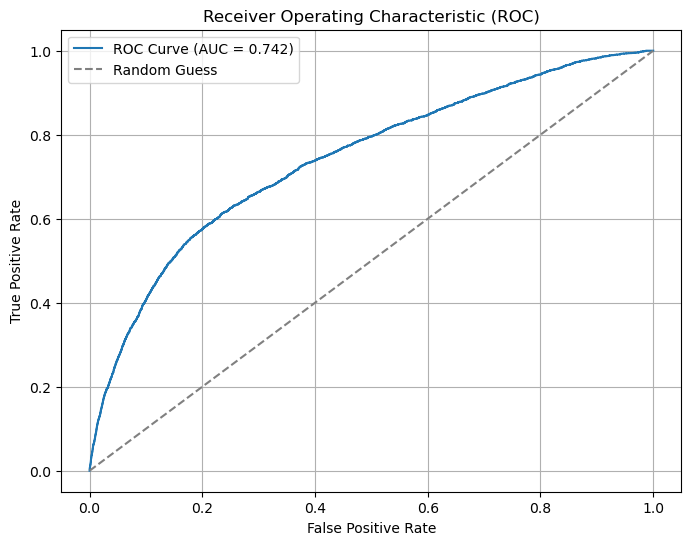

In [195]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid(True)
plt.show()

PR AUC (Average Precision): 0.186


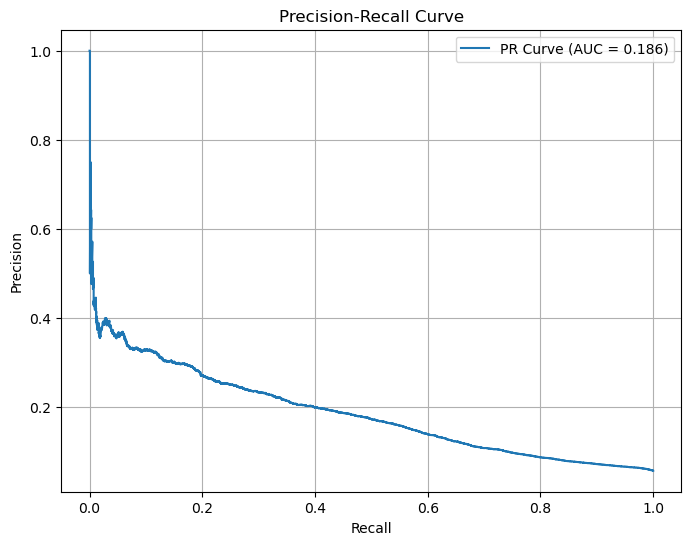

In [196]:
# Step 1: Get predicted probabilities for class 1
y_proba = xg_cv.predict_proba(gdf_test)[:, 1]

# Step 2: Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Step 3: Compute PR AUC (also called average precision)
pr_auc = average_precision_score(y_test, y_proba)
print(f"PR AUC (Average Precision): {pr_auc:.3f}")

# Step 4: Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# Compare the model

In [310]:
def best_f1(model, X, y_true,   step=0.001):

    # get predicted probabilities for class 1
    # if not hasattr(model, "predict_proba"):
    #     raise ValueError("Model must implement predict_proba")
    if model == 'neural_cv':
        y_proba = neural.predict(X)[:, 0]
    elif model == 'xg_cv': 
        gdf_test  = cudf.DataFrame.from_pandas(X)
        y_proba = xg_cv.predict_proba(gdf_test)[:, 1]
    elif model == 'forest_cv':
        y_proba = forest_cv.predict_proba(X)[:, 1]
    else: 
        y_proba = model_cv.predict_proba(X)[:, 1]

    
    thresholds = np.arange(0, 1 + step, step)

    best_threshold = None
    best_f1 = -np.inf
    scores = []

    for thr in thresholds:
        preds = (y_proba >= thr).astype(int)
        f1 = f1_score(y_true, preds, average='macro')
        scores.append({'threshold': thr, 'macro_f1': f1})
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thr

    df_scores = pd.DataFrame(scores)
    return best_threshold, best_f1, df_scores


In [311]:
best_threshold, best_f1_score, best_scores = best_f1('model_cv', x_test, y_test)
best_f1_score

np.float64(0.601967238809815)

In [312]:
best_threshold, best_f1_score, best_scores = best_f1('forest_cv', x_test, y_test)
best_f1_score

np.float64(0.6054668609450612)

In [313]:
best_threshold, best_f1_score, best_scores = best_f1('neural_cv', x_test, y_test)
best_f1_score

1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step


np.float64(0.5818781351311958)

In [314]:
best_threshold, best_f1_score, best_scores = best_f1(xg_cv, x_test, y_test)
best_f1_score

np.float64(0.601967238809815)

In [304]:
best_scores

,threshold,macro_f1
0,0.00,0.054130
1,0.05,0.187246
2,0.10,0.187246
3,0.15,0.187246
4,0.20,0.187246
5,0.25,0.187246
6,0.30,0.187246
7,0.35,0.187246
8,0.40,0.187246
9,0.45,0.187246


1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


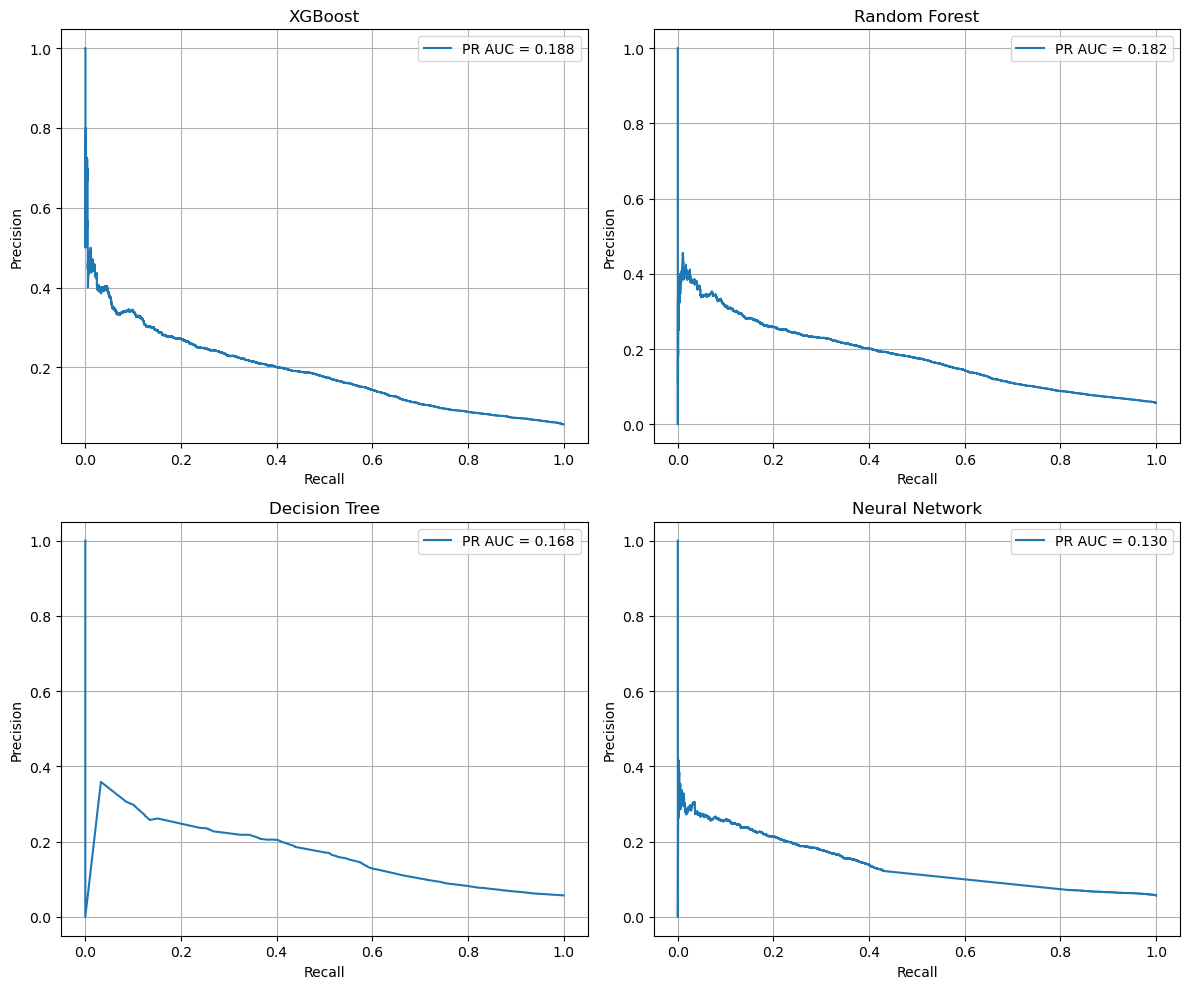

In [315]:
models = [xg_cv, forest_cv, model_cv, neural]
titles = ["XGBoost", "Random Forest", "Decision Tree", "Neural Network"]

# Create a 2×2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Loop through each model and plot its PR curve
for ax, model, title in zip(axes, models, titles):
    # Get predicted probabilities for the positive class
    if model is neural:
        y_proba = model.predict(x_test)[:, 0]
    elif model is xg_cv: 
        gdf_test  = cudf.DataFrame.from_pandas(x_test)
        y_proba = model.predict_proba(gdf_test)[:, 1]
    else: 
        y_proba = model.predict_proba(x_test)[:, 1]

    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)

    ax.plot(recall, precision, label=f"PR AUC = {ap:.3f}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Remove any unused subplots (if fewer than 4 models)
for i in range(len(models), 4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [340]:
y_proba = forest_cv.predict_proba(x_test)[:, 1] 

y_proba.shape

(58014,)

Text(0.5, 1.0, 'The distribution of likelihood across donors tested')

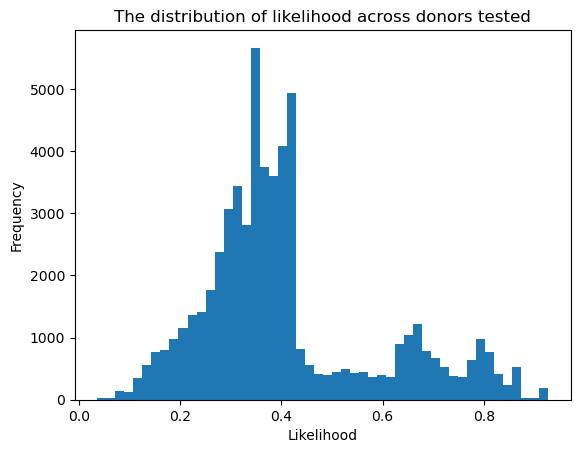

In [337]:
plt.hist(y_proba, bins = 50) 
plt.ylabel('Frequency')
plt.xlabel('Likelihood')
plt.title('The distribution of likelihood across donors tested')

In [339]:
y_proba.shape

(5574,)